This is a summary and cleaner version of the jupyter lab called: http://127.0.0.1:8888/lab/tree/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Get_data_for_modeing_2.ipynb

In this juper lab: 

    1. I first create a LSTM mode, with one input which are IFR of has two output : Sin and Cos of the angle of the animal around the lever
    2. Load the ifr of the cells (Mostly FS) and sin and cos of the angle of the animal around the lever 
    3. Generate the the model and get the labels and output and calculate the mse of the model 
    4. Reconstruct the angle of the animal around the lever and compare it to the predicted angle from the model 
    5. Calculate the shuffle value for angle of the animal around the lever and run the model on shuffled data. 
    6. Compare the r and mse from the shufled data with the original data. 
    
    7. Repeat this for all the sessions with at least 1 FS. 
    8. Calculate how many FS do we need to have to get the significant differences from the shuffled value. 
    

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *

In [2]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [ ]:
prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

#prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[64:67],myProject.sessionList[64:67]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


 53%|████████████████████████████████████████████████████▎                                             | 96/180 [01:38<01:30,  1.07s/it]

In [ ]:
for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
#for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
#for ses, sSes in tqdm(zip(myProject.sessionList[64:67],sSessions[64:67])):
    getSearchHomingIntervals(ses, sSes)

In [ ]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)

res = pd.read_csv(fn)
###
df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


In [19]:
fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myMaps = pickle.load(handle)


fn = "/adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMaps = pickle.load(handle)


loading /adata/projects/autopi_inter//results/myMaps.pickle
loading /adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle


In [ ]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    
    return sSes,ses,n, nid 

def plotLeverMap(axes, cluId, maps, df_HDInfoSingle, condition='all_light', r='none', showYLabel=True):
    
    '''
    plot the normal lever center maps 
    fsInd: is the index of the cell from the cells df
    '''
        
    nCells = maps["map"]["all_light"]["none"]['data'].shape[0]

    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break

    im = mapToPlot
    Lscore = df_HDInfoSingle[(df_HDInfoSingle.cluid == cluId) & (df_HDInfoSingle.light == condition)]['HD_score'].iloc[0]
    im = im[:, ~np.isnan(im).all(axis=0)]
    im = im[~np.isnan(im).all(axis=1), :]
    axes.imshow(im.T, origin="lower", cmap='jet', interpolation=None)
    
    if condition == 'all_light':
        condname = 'light'
    elif condition == 'all_dark':
        condname = 'dark'
        
    if r == 'none':
        rname = 'lever-location'
    else:
        #rname = 'arenaref'
        rname = 'cardinal'
    
    if r=='none':
        
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz\nmvl: {Lscore:.2f}\n{condname} - {rname}', fontsize=9)
    else:
        #axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} - {rname}', fontsize=10)
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} ', fontsize=10)
    axes.axis('off')

    
    
def plot_multiple_lever_maps(gs, cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8):
    for i, condition in enumerate(conditions):
        for j, r in enumerate(rs):
            ax = fig.add_subplot(gs[0, i*len(rs) + j])
            plotLeverMap(ax, cellIdToPlot, myLeverMaps, df_HDInfoSingle, condition=condition, r=r)


In [ ]:
def load_pose_around_lever_for_modeling(ses,sSes, interName= 'all_light' ,maxDistance= 18, rotationType="none", 
                                        invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12, ctype= 'fs' ):

    sSes.load_parameters_from_files()
    sSes.load_parameters_from_files()
    sSes.ap.load_pose_from_file() # get original hd data,

    ## Transfer the x,y position of the animal to the Lever Reference frame 
    toLeverReferenceFrame(ses=ses,sSes=sSes,maxDistance=maxDistance, rotationType="none", invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12)

    sSes.ap.set_intervals(ses.intervalDict[interName])
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(sSes)
    cg = Cell_group(stl, sSes.ap)

    # create a list of cells (spikeA.Neuron)
    if ctype== 'fs' :
        cids = cells[(cells.session == sSes.name) & (cells.mrate_RF1> 10) & (cells.interneuron)].cluId

    elif ctype== 'gc':
        cids = cells[(cells.session == sSes.name) & (cells.gridCell_FIRST)].cluId
    else:
        cids = cells[(cells.session == sSes.name)].cluId

    cIds = [cid.split("_")[1] for cid in cids]
    cg.sc_list = [n for n in cg.neuron_list if n.name in cIds]

    return sSes.ap, cg

In [ ]:
def get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses,interName= 'all_light', ctype= 'fs',  sigma_ifr= 5, maxDistance= 18, rotationType="none" ):
    """
    Get ifr  and the movement direction of the animal that matches the ap.pose samples
    
    """
    # load session files
    ap, cg = load_pose_around_lever_for_modeling(ses,sSes, interName= interName,maxDistance= maxDistance, rotationType=rotationType, 
                                        invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12, ctype= ctype)
    
    # trick to get aligned ifr and pose data
    time = ap.pose[:,0]
    bin_size_sec = np.diff(time)[0]
    
    pose = ap.pose[:,1:3]
    keepIndices = ~(np.isnan(pose[:,1]))
    pose= pose[keepIndices]
    
    angles = np.arctan2(pose[:,1], pose[:,0]) ## get values between -3,3 
    magnitude = np.sqrt(pose[:,0]**2 + pose[:,1]**2)
    #angles = np.mod(angles + 2 * np.pi, 2 * np.pi) ## get values between 0, 2*pi
    # Compute the sine and cosine of the angle
    sin_angle = pose[:,1] / magnitude
    cos_angle = pose[:,0] / magnitude

    sin_cos_angles = np.column_stack((sin_angle, cos_angle))
    
    if len(cg.sc_list)!= 0:

        for n in cg.sc_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            n.spike_train.instantaneous_firing_rate(bin_size_sec = bin_size_sec, sigma= sigma_ifr, time_start=min(time)-bin_size_sec/2, 
                                                time_end=max(time), outside_interval_solution="remove")

       
        ifr = np.stack([n.spike_train.ifr[0][keepIndices] for n in cg.sc_list])

        #### aligne the shape 
        time = time[keepIndices]
        ifr= ifr[:,:-1]
        time= time[:-1]
 
    else:
        ifr= np.nan
        time= time[:-1]

    return ifr, pose[:-1,:], time, angles[:-1], sin_cos_angles[:-1,:]

In [22]:
ses= myProject.sessionList[152]
sSes= sSessions[152]

bin_size_sec = 0.02
#interName= 'atLever_light'
maxDistance= 18 
sigma_ifr= 5
ctype= 'fs'


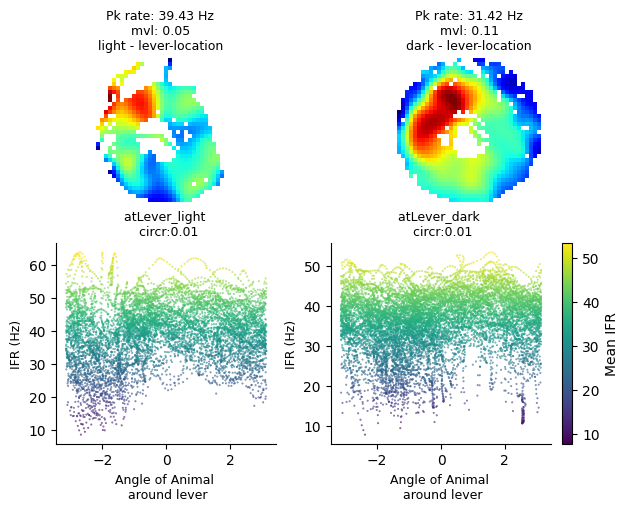

In [24]:

col = 6
row = 2
sizePerRow, sizePerCol = 2.5, 2.5
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


#### The Map of the cells 
session_cells = cells[(cells.session == sSes.name)]
conditions = ['all_light', 'all_dark']
rs = ['none']

celltoplot= session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[0].cluId
gscell = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,:2], wspace=0.0)
plot_multiple_lever_maps(gscell, celltoplot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8)
ax= fig.add_subplot(gs[1,0])
interName= 'atLever_light'
ifr, pose, time, angles, sin_cos_angles = get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses,
                                            interName= interName, ctype= 'fs',  sigma_ifr= 5, maxDistance= 18, rotationType="none" )

ax.scatter(angles, ifr.mean(axis= 0), c=ifr.mean(axis= 0), cmap='viridis', alpha=0.75, s= 0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Angle of Animal \n  around lever ', fontsize=9)##
ax.set_ylabel('IFR (Hz)', fontsize=9)
circr= circcorrcoef(angles, ifr.mean(axis= 0)) 
ax.set_title(f'{interName} \n circr:{circr:.2f}', fontsize=9)


ax= fig.add_subplot(gs[1,1])
interName= 'atLever_dark'
ifr, pose, time, angles, sin_cos_angles = get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses,
                                            interName= interName, ctype= 'fs',  sigma_ifr= 5, maxDistance= 18, rotationType="none" )

ax.scatter(angles, ifr.mean(axis= 0), c=ifr.mean(axis= 0), cmap='viridis', alpha=0.75, s= 0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Angle of Animal \n  around lever ', fontsize=9)##
ax.set_ylabel('IFR (Hz)', fontsize=9)
circr= circcorrcoef(angles, ifr.mean(axis= 0)) 
ax.set_title(f'{interName} \n circr:{circr:.2f}', fontsize=9)
plt.colorbar(plt.cm.ScalarMappable( cmap='viridis', norm=plt.Normalize(np.min(ifr.mean(axis= 0)), np.max(ifr.mean(axis= 0)))), ax=ax, label='Mean IFR')



# Build the lstm model 


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import mean_squared_error 
import datetime


class NeuralDataset(torch.utils.data.Dataset):
    """
    Represent our pose and neural data.
    
    """
    def __init__(self, ifr, sin, cos, time, seq_length,ifr_normalization_means=None,ifr_normalization_stds=None):    
        """
        ifr: instantaneous firing rate
        angle: angle of the animal around the lever from -pi to pi 
        seq_length: length of the data passed to the network
        """
        super(NeuralDataset, self).__init__()
        self.ifr = ifr.astype(np.float32)
        #self.sin_cos_angles = sin_cos_angles.astype(np.float32)
        self.sin = sin.astype(np.float32)
        self.cos= cos.astype(np.float32)
        self.time = time.astype(np.float32)
        self.seq_length = seq_length
        
        self.ifr_normalization_means=ifr_normalization_means
        self.ifr_normalization_stds=ifr_normalization_stds
        
        self.normalize_ifr()
        
        #self.validIndices = np.argwhere(~np.isnan(self.angel[:]))
        self.validIndices = np.argwhere(~np.isnan(self.sin[:]))
        self.validIndices = self.validIndices[self.validIndices>seq_length] # make sure we have enough neural dat leading to the angles
   
        
    def normalize_ifr(self):
        """
        Set the mean of each neuron to 0 and std to 1
        Neural networks work best with inputs in this range
        Set maximal values at -5.0 and 5 to avoid extreme data points
        
        ###########
        # warning #
        ###########
        
        In some situation, you should use the normalization of the training set to normalize your test set.
        For instance, if the test set is very short, you might have a very poor estimate of the mean and std, or the std might be undefined if a neuron is silent.
        """
        if self.ifr_normalization_means is None:
            self.ifr_normalization_means = self.ifr.mean(axis=0)
            self.ifr_normalization_stds = self.ifr.std(axis=0)
            
        self.ifr = (self.ifr-np.expand_dims(self.ifr_normalization_means,0))/np.expand_dims(self.ifr_normalization_stds,axis=0)
        self.ifr[self.ifr> 5.0] = 5.0
        self.ifr[self.ifr< -5.0] = -5.0
        
        
    def __len__(self):
        return len(self.validIndices)
    
    def __getitem__(self,index):
        """
        Function to get an item from the dataset
        
        Returns angles, neural data
        
        """
        neuralData = self.ifr[self.validIndices[index]-self.seq_length:self.validIndices[index],:]
        #sin_cos_angles = self.angle[self.validIndices[index]:self.validIndices[index]+1,:]#. 2d array 
        sin= self.sin[self.validIndices[index]:self.validIndices[index]+1].squeeze()  # Squeeze to get shape [1] instead of [1, 1]
        cos= self.cos[self.validIndices[index]:self.validIndices[index]+1].squeeze()  # Squeeze to get shape [1] instead of [1, 1]
        time = self.time[self.validIndices[index]:self.validIndices[index]+1]
        
        #return torch.from_numpy(neuralData), torch.from_numpy(sin_cos_angles).squeeze(), torch.from_numpy(time) # if I return sin_cos_angle in a 2d array
        return torch.from_numpy(neuralData), torch.from_numpy(sin), torch.from_numpy(cos), torch.from_numpy(time)
    
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_outputs, sequence_length, device):
        super(LSTM,self).__init__()
        """
        For more information about nn.LSTM -> https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        """
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size,hidden_size, num_layers, batch_first=True)
        # input : batch_size x sequence x features
        self.device = device
        self.fc = torch.nn.Linear(hidden_size*sequence_length, num_outputs) # if you onely want to use the last hidden state (hidden_state,num_classes)
        #self.fc = torch.nn.Linear(hidden_size * sequence_length, 2)  # Output two values for sin and cos but in a single 2d array  
        
    def forward(self,x):
        
        h0 =  torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(self.device)
        c0 =  torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(self.device) 
        out, _ = self.lstm(x,(h0,c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out) #if you want to use only the last hidden state, remove previous line, # out = self.fc(out[:,-1,:])
        
        return out

In [ ]:
def split_to_test_andTraining(ifr, pose, sin_cos_angles, time, angles):

    split_index = int(ifr.shape[1] * 0.8)  # 80% of the data along the second axis
    train_ifr = ifr[:, :split_index]  # First 80% for training
    test_ifr = ifr[:, split_index:]
    
    train_pose= pose[:split_index, :]
    test_pose= pose[split_index:, :]
    
    train_sin_cos_angles= sin_cos_angles[:split_index, :]
    test_sin_cos_angles= sin_cos_angles[split_index:, :]
    
    train_time=time[:split_index]
    test_time= time[split_index:]
    
    train_angles=angles[:split_index]
    test_angles= angles[split_index:]
    
    return train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles

import numpy as np

def get_shuffled_data(interName, sin_cos_angles, ses, min_roll_sec=20):
    # Get the interval times for the specified interName
    intervals = ses.intervalDict[interName]
    total_time_sec = intervals[:, 1][-1] - intervals[:, 0][0]

    # Ensure the total interval duration is larger than 2 * min_roll_sec
    if total_time_sec < 2 * min_roll_sec:
        raise ValueError("Total time in intervals should be larger than 2 * min_roll_sec")

    # Generate a random shift within the allowed range
    time_shift = np.random.default_rng().uniform(min_roll_sec, total_time_sec - min_roll_sec, 1)
    angles = np.arctan2(sin_cos_angles[:, 0], sin_cos_angles[:, 1])

    # Calculate time per data point
    time_per_datapoint = angles[1] - angles[0]
    shift = int(time_shift / time_per_datapoint)

    # Apply the shift to the angles
    rolled_angles = np.roll(angles, shift=shift, axis=0)

    # Convert the shifted angles back to sin and cos components
    rolled_sin_cos = np.column_stack((np.sin(rolled_angles), np.cos(rolled_angles)))

    return rolled_sin_cos


In [ ]:
def get_test_training_datas_oneSession(sSes, ses, interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none", shuffle=True):

    # 1. Split the time interval for training and testing
    intervals= ses.intervalDict[interName]
    ifr, pose, time, angles, sin_cos_angles = get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses, interName= interName, ctype= ctype,  sigma_ifr= sigma_ifr, maxDistance= maxDistance, rotationType= rotationType )
    
    if shuffle: 
        sin_cos_angles_shuffled= get_shuffled_data( interName, sin_cos_angles,ses, min_roll_sec=20)
        train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles = split_to_test_andTraining(ifr,
                                pose, sin_cos_angles_shuffled, time, angles)
        train_ifr = train_ifr.T 
        test_ifr = test_ifr.T

    
    else: 
        
        train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles = split_to_test_andTraining(ifr, pose, sin_cos_angles, time, angles)
        train_ifr = train_ifr.T 
        test_ifr = test_ifr.T
    
    ####################
    ### Get the config file 
    #############
    ###################

    config = {"seq_length":20, ## is this the length of the 
              "n_cells": train_ifr.shape[1], ## it was the num of cells for one neuron is always 1
              "hidden_size" :256,
              "num_layers" : 2,
              "num_outputs" : 2, # 2 number of vector unit in x and y since I want to calculate the movement direction 
              "learning_rate" : 0.001,#0.001, ## 0.001 ( sme was )
              "dropout_rate": 0.05,
              "batch_size" :64, #64,
              "num_epochs": 100}

    print(datetime.datetime.now(), config)
    #print(datetime.now(), config)
    # 4. Create train and test datasets
    train_dataset = NeuralDataset(
        ifr=train_ifr[:, :config["n_cells"]],
        #angle=train_angles,
        sin= train_sin_cos_angles[:,0], ### instead of 
        cos= train_sin_cos_angles[:,1],
        time=train_time,
        seq_length=config["seq_length"]
    )

    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds

    myDict = {
        "ifr_normalization_means": ifr_normalization_means,
        "ifr_normalization_stds": ifr_normalization_stds
    }

    test_dataset = NeuralDataset(
        ifr=test_ifr[:, :config["n_cells"]],
        #angle=test_angles,
        sin= test_sin_cos_angles[:,0],
        cos= test_sin_cos_angles[:,1],
        time=test_time,
        seq_length=config["seq_length"],
        ifr_normalization_means=ifr_normalization_means,
        ifr_normalization_stds=ifr_normalization_stds)

    # 5. Create data loaders
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config["batch_size"],
        num_workers=1, shuffle=True, pin_memory=False, drop_last=True)

    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config["batch_size"],
        num_workers=1, shuffle=False, pin_memory=False)

    return train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config

def lossOnTestDataset(model, test_data_loader, device, loss_fn):
    model.eval()
    loss_test = 0
    with torch.no_grad():
        for imgs, sin_labels, cos_labels, time in test_data_loader:
            imgs = imgs.to(device)
            sin_labels = sin_labels.to(device)
            cos_labels = cos_labels.to(device)

            outputs = model(imgs)  # Model outputs both sin and cos
            
            # Assume outputs[:, 0] is for sin and outputs[:, 1] is for cos
            sin_outputs = outputs[:, 0]
            cos_outputs = outputs[:, 1]

            # Calculate loss for both sin and cos
            loss_sin = loss_fn(sin_outputs, sin_labels)
            loss_cos = loss_fn(cos_outputs, cos_labels)
            
            # Total loss (sum of both)
            loss = loss_sin + loss_cos
            loss_test += loss.item()
    
    model.train()  # Set model back to training mode
    
    if len(test_data_loader) == 0:  # Handle case where the loader is empty
        return float('inf')  # Or return some placeholder value to indicate no test data
    
    return loss_test / len(test_data_loader)


def training_loop(n_epochs,
                  optimizer,
                  model,
                  loss_fn,
                  train_data_loader,
                  test_data_loader,
                  config,
                  device,
                  verbose=False,
                  best_loss=float('inf'),
                  best_model_state=None):
    
    if verbose:
        print("Training starting at {}".format(datetime.datetime.now()))
    
    # Evaluate initial loss without training
    testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)
    trainLoss = lossOnTestDataset(model, train_data_loader, device, loss_fn)
    
    if verbose:
        print(f"Test loss without training: {testLoss}")
    
    df = pd.DataFrame({
        "epochs": [0],
        "seq_length": config["seq_length"],
        "n_cells": config["n_cells"],
        "hidden_size": config["hidden_size"],
        "num_layers": config["num_layers"],
        "learning_rate": config["learning_rate"],
        "batch_size": config["batch_size"],
        "train_loss": trainLoss,
        "test_loss": testLoss
    })

    for epoch in range(1, n_epochs + 1):
        loss_train = 0
        model.train()  # Set model to training mode

        for imgs, sin_labels, cos_labels, time in train_data_loader:  # Expect 4 values
            imgs = imgs.to(device)
            sin_labels = sin_labels.to(device).squeeze()  # Ensure sin_labels shape is [64] instead of [64, 1]
            cos_labels = cos_labels.to(device).squeeze()  # Ensure cos_labels shape is [64] instead of [64, 1]

            # Forward pass
            outputs = model(imgs)  # Model outputs both sin and cos
            sin_outputs = outputs[:, 0]  # First output is sin
            cos_outputs = outputs[:, 1]  # Second output is cos

            # Compute losses for both sin and cos predictions
            loss_sin = loss_fn(sin_outputs, sin_labels)
            loss_cos = loss_fn(cos_outputs, cos_labels)

            # Total loss as the sum of both
            loss = loss_sin + loss_cos

            optimizer.zero_grad()  # Clear gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            loss_train += loss.item()  # Accumulate loss
        
        # Calculate loss on test set
        testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)

        if verbose:
            print(f"{datetime.datetime.now()} Epoch: {epoch}/{n_epochs}, "
                  f"Training loss: {loss_train/len(train_data_loader)}, "
                  f"Testing loss: {testLoss}")

        # Record training statistics
        df1 = pd.DataFrame({
            "epochs": [epoch],
            "seq_length": config["seq_length"],
            "n_cells": config["n_cells"],
            "hidden_size": config["hidden_size"],
            "num_layers": config["num_layers"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "train_loss": loss_train / len(train_data_loader),
            "test_loss": testLoss
        })

        df = pd.concat([df, df1])

        # Save the best model state based on test loss
        if testLoss < best_loss:
            best_loss = testLoss
            best_model_state = model.state_dict()

    return df, best_model_state


In [ ]:
def Makeprediction(model, test_data_loader, device):
    model.eval()
    labellists_sin = []
    labellists_cos = []
    outputlists_sin = []
    outputlists_cos = []
    
    with torch.no_grad():
        for imgs, sin_labels, cos_labels, time in test_data_loader:  # mini-batches with data loader
            imgs = imgs.to(device=device)
            
            # Move labels to CPU
            sin_labels = sin_labels.to('cpu').numpy()
            cos_labels = cos_labels.to('cpu').numpy()
            
            # Predict outputs
            outputs = model(imgs)
            sin_outputs = outputs[:, 0].to('cpu').detach().numpy()  # First output: sin
            cos_outputs = outputs[:, 1].to('cpu').detach().numpy()  # Second output: cos

            # Append predictions and labels
            outputlists_sin.append(sin_outputs)
            outputlists_cos.append(cos_outputs)
            labellists_sin.append(sin_labels)
            labellists_cos.append(cos_labels)
    
    return labellists_sin, labellists_cos, outputlists_sin, outputlists_cos

def get_labels_and_outputs_mse(model, test_data_loader, device):
    ''' 
        This is a func to run the models on the slected cell types and
        returns:
        
         1. mean square error of the model
         2. labesl and the outputs (concatenated for the selected cells)
         
    '''
    
    #labellists, outputlists = Makeprediction(model,test_data_loader,device=device)
    labellists_sin, labellists_cos, outputlists_sin, outputlists_cos= Makeprediction(model, test_data_loader, device)
    labels_sin= np.concatenate(labellists_sin)
    labels_cos= np.concatenate(labellists_cos)
    outputs_sin= np.concatenate(outputlists_sin)
    outputs_cos= np.concatenate(outputlists_cos)
        
    outputs= np.column_stack((outputs_sin, outputs_cos))
    labels= np.column_stack((labels_sin, labels_cos))
    
    mse_sin= mean_squared_error(labels_sin,outputs_sin) 
    mse_cos= mean_squared_error(labels_cos,outputs_cos)
    
    #mse= np.column_stack((mse_sin, mse_cos))
    mse = (mse_sin, mse_cos)
    
    return mse, outputs, labels

Need to modify the the funx to get the test and training dataset with the possibility to get the shuffled value 

In [31]:
sigma_ifr= 5
ses= myProject.sessionList[152]
sSes= sSessions[152]

ctype= 'fs'
interName= 'atLever_light'
maxDistance= 18 
rotationType= 'none'

#intervals= ses.intervalDict[interName]

## get test and training dataset
train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses,
                                                    interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none", shuffle=False)
### get my model 
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
print("Device available:", device)

#optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
loss_fn = torch.nn.MSELoss() # 
model.train()


### train the model 
df, best_model_state = training_loop(n_epochs=config["num_epochs"],
             optimizer=optimizer,
             model = model,
             loss_fn = loss_fn,
             train_data_loader=train_data_loader,
             test_data_loader=test_data_loader, #changed to look at prediction in training dataset
             config=config,
             device = device,
             verbose=True)

2024-11-04 22:49:10.197613 {'seq_length': 20, 'n_cells': 14, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
Device available: cuda
Training starting at 2024-11-04 22:49:11.978414
Test loss without training: 1.0095738222201665
2024-11-04 22:49:13.501032 Epoch: 1/100, Training loss: 0.9886971451342106, Testing loss: 0.9725472157200178
2024-11-04 22:49:14.271454 Epoch: 2/100, Training loss: 0.9584041809042295, Testing loss: 0.9481864472230276
2024-11-04 22:49:15.082221 Epoch: 3/100, Training loss: 0.9335571701327959, Testing loss: 0.9254375273982683
2024-11-04 22:49:15.921558 Epoch: 4/100, Training loss: 0.9099731637785832, Testing loss: 0.9024247974157333
2024-11-04 22:49:16.728557 Epoch: 5/100, Training loss: 0.8858970950047175, Testing loss: 0.8785967876513799
2024-11-04 22:49:17.577005 Epoch: 6/100, Training loss: 0.8614574881891409, Testing loss: 0.8538610513011614
2024-11-04 22:49:18.419437 Ep

In [32]:
mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)

In [33]:
labels_test[:,0].shape, outputs_test[:,0].shape

((1535,), (1535,))

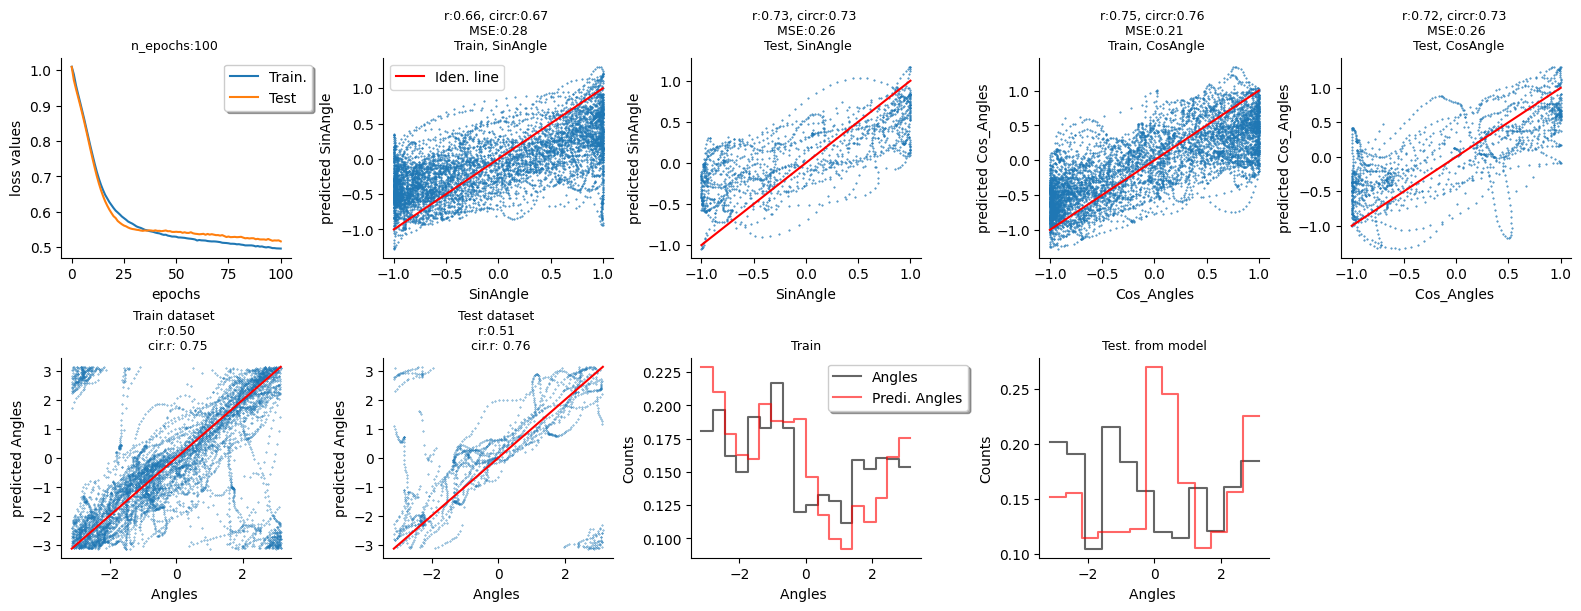

In [34]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

ax= fig.add_subplot(gs[0,0])
ax.plot(df.epochs, df.train_loss, label= 'Train.')
ax.plot(df.epochs, df.test_loss, label= 'Test')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc= 'center')
ax.set_xlabel('epochs')
ax.set_ylabel('loss values')
ax.set_title('n_epochs:{} ' .format(config['num_epochs']), fontsize=9)
ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)

ax= fig.add_subplot(gs[0,1])
#sns.kdeplot(labels, outputs)
ax.scatter(labels_train[:,0], outputs_train[:,0], s= 0.2)
ax.set_xlabel('SinAngle')##
ax.set_ylabel('predicted SinAngle')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

r,p= pearsonr(labels_train[:,0], outputs_train[:,0])
circr= circcorrcoef(labels_train[:,0], outputs_train[:,0]) 

# plot the identity line
ax.plot([min(labels_train[:,0]), max(labels_train[:,0])], [min(labels_train[:,0]), max(labels_train[:,0])], color='red', label=f'Iden. line')
ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, SinAngle' .format(r,circr, mse_train[0]), fontsize=9)
# Add legend
plt.legend()


ax= fig.add_subplot(gs[0,2])
#sns.kdeplot(labels, outputs)
ax.scatter(labels_test[:,0], outputs_test[:,0], s= 0.2)
ax.set_xlabel('SinAngle')##
ax.set_ylabel('predicted SinAngle')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
r,p= pearsonr(labels_test[:,0], outputs_test[:,0])
circr= circcorrcoef(labels_test[:,0], outputs_test[:,0]) 

# plot the identity line
ax.plot([min(labels_test[:,0]), max(labels_test[:,0])], [min(labels_test[:,0]), max(labels_test[:,0])], color='red', label=f'Iden. line')
ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, SinAngle' .format(r,circr, mse_test[0]), fontsize=9)
# Add legend
#ax.legend(loc='upper center', bbox_to_anchor=(1, 1.3), fancybox=True, shadow=True)

ax= fig.add_subplot(gs[0,3])
#sns.kdeplot(labels, outputs)
ax.scatter(labels_train[:,1], outputs_train[:,1], s= 0.2)
ax.set_xlabel('Cos_Angles')##
ax.set_ylabel('predicted Cos_Angles')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

r,p= pearsonr(labels_train[:,1], outputs_train[:,1]) ## labels are the Angles
circr= circcorrcoef(labels_train[:,1], outputs_train[:,1]) ## outputs are the pred_angles
# plot the identity line
ax.plot([min(labels_train[:,1]), max(labels_train[:,1])], [min(labels_train[:,1]), max(labels_train[:,1])], color='red', label=f'Iden. line')
ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, CosAngle' .format(r,circr, mse_train[1]), fontsize=9)
# Add legend


ax= fig.add_subplot(gs[0,4])
#sns.kdeplot(labels, outputs)
ax.scatter(labels_test[:,1], outputs_test[:,1], s= 0.2)
ax.set_xlabel('Cos_Angles ')##
ax.set_ylabel('predicted Cos_Angles')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

r,p= pearsonr(labels_test[:,1], outputs_test[:,1])
circr= circcorrcoef(labels_test[:,1], outputs_test[:,1]) 

# plot the identity line
ax.plot([min(labels_test[:,1]), max(labels_test[:,1])], [min(labels_test[:,1]), max(labels_test[:,1])], color='red', label=f'Iden. line')
ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, CosAngle' .format(r,circr, mse_test[1]), fontsize=9)
# Add legend

###########################
#### plot the original angle vs predicted angle in test and training datasets: 
#############################

Angle_train = np.arctan2(labels_train[:,0], labels_train[:,1])
Angle_train_pred = np.arctan2(outputs_train[:,0], outputs_train[:,1])


Angle_test = np.arctan2(labels_test[:,0], labels_test[:,1])
Angle_test_pred = np.arctan2(outputs_test[:,0], outputs_test[:,1])

################
##################
##
###############
##############
ax= fig.add_subplot(gs[1,0])
ax.scatter(Angle_train, Angle_train_pred, s= 0.1)
ax.set_xlabel('Angles ')##
ax.set_ylabel('predicted Angles')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

r,p= pearsonr(Angle_train, Angle_train_pred)
circr= circcorrcoef(Angle_train, Angle_train_pred) 

ax.set_title('Train dataset \n r:{:.2f} \n cir.r: {:.2f}'.format(r,circr ), fontsize=9)

# plot the identity line
ax.plot([min(Angle_train), max(Angle_train)], [min(Angle_train_pred), max(Angle_train_pred)], color='red', label=f'Iden. line')


ax= fig.add_subplot(gs[1,1])
ax.scatter(Angle_test, Angle_test_pred, s= 0.1)
ax.set_xlabel('Angles ')##
ax.set_ylabel('predicted Angles')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

r,p= pearsonr(Angle_test, Angle_test_pred)
circr= abs(circcorrcoef(Angle_test, Angle_test_pred))

ax.set_title('Test dataset \n r:{:.2f}  \n cir.r: {:.2f}'.format(r, circr), fontsize=9)
# plot the identity line
ax.plot([min(Angle_test), max(Angle_test)], [min(Angle_test_pred), max(Angle_test_pred)], color='red', label=f'Iden. line')


## 
ax= fig.add_subplot(gs[1,2])
sns.histplot(Angle_train, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
sns.histplot(Angle_train_pred, color='r', label='Predi. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
ax.set_title('Train', fontsize=9)
ax.set_xlabel('Angles ')##
ax.set_ylabel('Counts')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


ax= fig.add_subplot(gs[1,3])
sns.histplot(Angle_test, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
sns.histplot(Angle_test_pred, color='r', label='Predic. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
ax.set_title('Test. from model', fontsize= 9)
ax.set_xlabel('Angles ')##
ax.set_ylabel('Counts')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend()

# Calculate the shuffle value 

Need to run the shuffeling for at  least  500 times 

In [ ]:
def run_and_evaluate_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5, shuffle=True):
    
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:
        
        ## Get the test and train Dataset for each shuffle
        train_dataset, test_dataset, train_loader, test_loader, _, config = get_test_training_datas_oneSession(
            sSes, ses, interName, ctype=ctype, sigma_ifr=sigma_ifr, shuffle=shuffle
        )

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"], config["seq_length"], device=device).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])
        loss_fn = torch.nn.MSELoss()

        # Train the model
        df, _ = training_loop(
            n_epochs=config["num_epochs"], optimizer=optimizer, model=model,
            loss_fn=loss_fn, train_data_loader=train_loader, test_data_loader=test_loader,
            config=config, device=device, verbose=False
        )

        # Get labels and predictions
        mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_loader, device)
        mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_loader, device)

        # Calculate angles
        angles = {}

        if shuffle == True: 

            for split, labels, outputs in zip(['train', 'test'], [labels_train, labels_test], [outputs_train, outputs_test]):
                angles[f'{split}_shuffled'] = np.arctan2(labels[:, 0], labels[:, 1])
                angles[f'{split}_pred_shuffled'] = np.arctan2(outputs[:, 0], outputs[:, 1])

            # Calculate correlations
            metrics = {
                'r_train': pearsonr(angles['train_shuffled'], angles['train_pred_shuffled'])[0],
                'circr_train': circcorrcoef(angles['train_shuffled'], angles['train_pred_shuffled']),
                'r_test': pearsonr(angles['test_shuffled'], angles['test_pred_shuffled'])[0],
                'circr_test': circcorrcoef(angles['test_shuffled'], angles['test_pred_shuffled']),
                'df': df,
            }
        else:
            for split, labels, outputs in zip(['train', 'test'], [labels_train, labels_test], [outputs_train, outputs_test]):
                angles[f'{split}'] = np.arctan2(labels[:, 0], labels[:, 1])
                angles[f'{split}_pred'] = np.arctan2(outputs[:, 0], outputs[:, 1])

            # Calculate correlations
            metrics = {
                'r_train': pearsonr(angles['train'], angles['train_pred'])[0],
                'circr_train': circcorrcoef(angles['train'], angles['train_pred']),
                'r_test': pearsonr(angles['test'], angles['test_pred'])[0],
                'circr_test': circcorrcoef(angles['test'], angles['test_pred']),
                'df': df,
            }

        return {**angles, **metrics}

def Get_shuffle_values_one_session(sSes, ses, interName, iteration= 500): 
    results = []
    for _ in tqdm(range(iteration)):
        angles_and_metrics = run_and_evaluate_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5, shuffle=True)
        results.append(angles_and_metrics)

    # Convert results to a DataFrame
    df_sSes = pd.DataFrame(results)
      
    return df_sSes

def plot_shuffled_rvalues_oneSession(gs,df_sSes, Angle_test, Angle_test_pred ,iteration= 500 ):

    
    ax= fig.add_subplot(gs[0])
    ax.hist(df_sSes.r_test)
    threshold= np.percentile(df_sSes.r_test,95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    ax.axvline(x=r_original, color='red', linestyle='-', linewidth=2, label='ori. r')
    ax.set_title(f'Test dataset \n itteration:{iteration}, n_fs:{df_sSes.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Pearson r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


    ax= fig.add_subplot(gs[1])
    ax.hist(abs(df_sSes.circr_test))
    threshold= np.percentile(abs(df_sSes.circr_test),95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    ax.axvline(x=circr, color='red', linestyle='-', linewidth=2, label='ori. circr')
    ax.set_title(f'Test dataset \n itteration:{iteration}, n_fs:{df_sSes.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Circular r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


In [14]:
sigma_speed= 5; sigma_ifr= 5
ses= myProject.sessionList[152]
sSes= sSessions[152]
ctype= 'fs'
interName= 'atLever_light'
#intervals= ses.intervalDict[interName]


In [ ]:
df_sSes= Get_shuffle_values_one_session(sSes, ses, interName, shuffle_times= 500)

In [ ]:
fn= f'shuffle_{sSes.name}.pkl'
df_sSes.to_pickle(fn)


In [37]:
## load a pickle file
fn= f'shuffle_{sSes.name}.pkl'
df_sSes = pd.read_pickle(fn)


In [38]:
df_sSes.keys() , df_sSes.df.iloc[0].keys()

(Index(['train_shuffled', 'train_pred_shuffled', 'test_shuffled',
        'test_pred_shuffled', 'r_train', 'circr_train', 'r_test', 'circr_test',
        'df'],
       dtype='object'),
 Index(['epochs', 'seq_length', 'n_cells', 'hidden_size', 'num_layers',
        'learning_rate', 'batch_size', 'train_loss', 'test_loss'],
       dtype='object'))

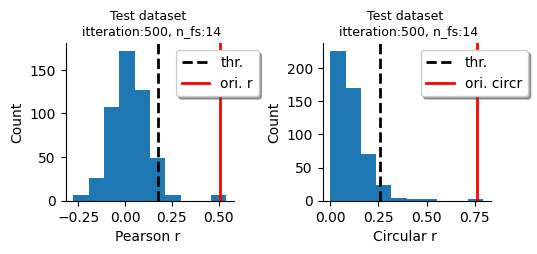

In [39]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

plot_shuffled_rvalues_oneSession(gs,df_sSes, Angle_test, Angle_test_pred ,iteration= 500 )

## Run the model on all sessions

In [40]:
#session_data = run_and_evaluate_model(sSessions[0], myProject.sessionList[0], interName,cells, ctype='fs', sigma_ifr=5, shuffle=False)

In [ ]:
all_sessions_data = []
save_directory= '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Sessions_model/'
interNames = ['atLever_light', 'atLever_dark']

# Loop through each session and each interval, processing and saving the data
for sSes, ses in tqdm(zip(sSessions, myProject.sessionList)):
    
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:

        for interName in interNames:
            try:

                # Run model for each session and interval
                session_data = run_and_evaluate_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5, shuffle=False)

                # Append the data to the list of all sessions and intervals
                all_sessions_data.append({**session_data, 'session': sSes.name, 'interval': interName})

                # Save the individual session and interval data immediately
                session_filename = os.path.join(save_directory, f"{sSes.name}_{interName}_model.pkl")
                with open(session_filename, 'wb') as f:
                    pickle.dump(session_data, f)

                print(f"Saved data for session {sSes.name}, interval {interName}")

            except Exception as e:
                print(f"Error processing session {sSes.name}, interval {interName}: {e}")

# After all sessions and intervals, save the combined data as a single file
all_sessions_filename = '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Sessions_model/allSessions.pkl'
with open(all_sessions_filename, 'wb') as f:
    pickle.dump(all_sessions_data, f)


## load the final lists of dictionaries 

In [ ]:
fn= '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Sessions_model/allSessions.pkl'
# Replace 'your_file.pkl' with the path to your pickle file
with open(fn, 'rb') as f:
    all_sessions_data = pickle.load(f)

all_sessions_df= pd.concat([pd.DataFrame([d]) for d in all_sessions_data], ignore_index=True)

## save the final df to a pickle file 
all_sessions_df.to_pickle(fn)

 From now on I can just load the final df from a pickle file 
 
 Sanity check to see if the length of the df is correct 

In [22]:
fn= '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Sessions_model/allSessions.pkl'
all_sessions_df = pd.read_pickle(fn)


In [23]:
 153*2, all_sessions_df.shape

(306, (306, 11))

In [24]:
all_sessions_df.keys()

Index(['train', 'train_pred', 'test', 'test_pred', 'r_train', 'circr_train',
       'r_test', 'circr_test', 'df', 'session', 'interval'],
      dtype='object')

Get the number of sessions that have more or equal to 1 FS cell:

In [21]:
filtered_cells = cells[(cells['interneuron']) & (cells['mrate_RF1'] > 10)]
session_counts = filtered_cells.groupby('session').size()

# Count how many sessions have more than one FS cell meeting the criteria
num_sessions = (session_counts >= 1).sum()
num_sessions



153

In [26]:
all_sessions_df.keys()

Index(['train', 'train_pred', 'test', 'test_pred', 'r_train', 'circr_train',
       'r_test', 'circr_test', 'df', 'session', 'interval'],
      dtype='object')

In [27]:
all_sessions_df.df.iloc[0].keys()

Index(['epochs', 'seq_length', 'n_cells', 'hidden_size', 'num_layers',
       'learning_rate', 'batch_size', 'train_loss', 'test_loss'],
      dtype='object')

Need now to run the shuffling for all the sessions since the shuffling takes so long .. now we wanna create a list of sessions that have more than or wqual to 5 FS cells 

In [28]:
sessionList = session_counts[session_counts >= 7].index.tolist()

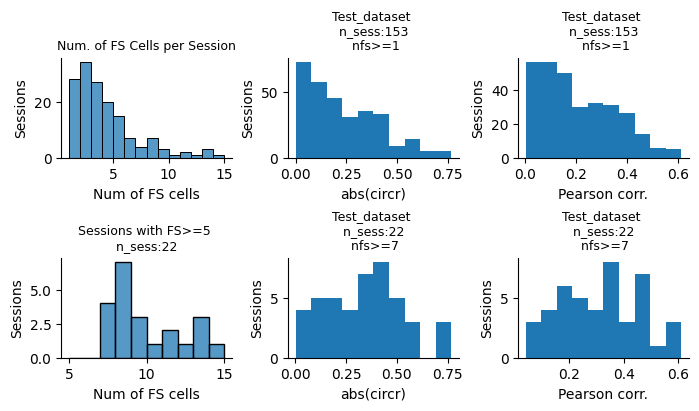

In [29]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ax= fig.add_subplot(gs[0])
sns.histplot(session_counts, bins=range(1, session_counts.max() + 2), kde=False)
plt.xlabel('Num of FS cells')
plt.ylabel('Sessions')
plt.title('Num. of FS Cells per Session', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax= fig.add_subplot(gs[1])
ax.hist(abs(all_sessions_df.circr_test))
ax.set_xlabel('abs(circr)')##
ax.set_ylabel('Sessions')
ax.set_title(f'Test_dataset \n n_sess:{num_sessions} \n nfs>=1', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax= fig.add_subplot(gs[2])
ax.hist(abs(all_sessions_df.r_test))
ax.set_xlabel('Pearson corr.')##
ax.set_ylabel('Sessions')
ax.set_title(f'Test_dataset \n n_sess:{num_sessions} \n nfs>=1', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax= fig.add_subplot(gs[1,0])
session_counts_5_or_more = session_counts[session_counts >= 7]
sns.histplot(session_counts_5_or_more, bins=range(5, session_counts_5_or_more.max() + 2), kde=False)
ax.set_xlabel('Num of FS cells')
ax.set_ylabel('Sessions')
ax.set_title(f'Sessions with FS>=5 \n n_sess:{len(sessionList)} ', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax= fig.add_subplot(gs[1,1])
ax.hist(abs(all_sessions_df[all_sessions_df.session.isin(sessionList)].circr_test))
ax.set_xlabel('abs(circr)')##
ax.set_ylabel('Sessions')
ax.set_title(f'Test_dataset \n n_sess:{len(sessionList)} \n nfs>=7',  fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax= fig.add_subplot(gs[1,2])
ax.hist(abs(all_sessions_df[all_sessions_df.session.isin(sessionList)].r_test))
ax.set_xlabel('Pearson corr.')##
ax.set_ylabel('Sessions')
ax.set_title(f'Test_dataset \n n_sess:{len(sessionList)} \n nfs>=7', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Run shuffle on all session s for all sessions 

All the functions that I need to run the shuffling on all the sessions are located in lstmModel.py and I would need to import all the funs fro that file in order to be able to run the pool. 

At the moment I am running the modeling only for 22 sessions that have 7 or more FS cells.


In [22]:
len(session_counts[session_counts >= 10].index.tolist())

8

In [9]:
from multiprocessing import Pool
from functools import partial
import os
from datetime import datetime
from tqdm import tqdm
import traceback
from concurrent.futures import ProcessPoolExecutor

save_directory = '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Shuffled_values/'
os.makedirs(save_directory, exist_ok=True)

# Define intervals to process
interNames = ['atLever_light', 'atLever_dark']
iteration = 500


In [12]:
def process_session_intervals_withShuffles(sSes, ses, interNames, cells, iteration=500):
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    
    if FS_count >= 10:
        for interName in interNames:
            # Define the file path
            filename = f"{sSes.name}_{interName}_shuffled_values.pkl"
            file_path = os.path.join(save_directory, filename)
            
            # Check if the file already exists
            if os.path.exists(file_path):
                print(f"File {filename} already exists. Skipping.")
                continue  # Skip to the next interval if file exists
            
            # Process each interval and save the DataFrame
            df_sSes = Get_shuffle_values_one_session(sSes, ses, interName, iteration=iteration)
            df_sSes.to_pickle(file_path)
            print(f"Saved data for {filename} at {file_path}")
            del df_sSes
            gc.collect()
            
# Define the wrapper function to accept session pairs
def process_session_wrapper(session_pair, interNames, cells, iteration):
    sSes, ses = session_pair  # Unpack the session pair
    #print(sSes)
    process_session_intervals_withShuffles(sSes, ses, interNames, cells, iteration=iteration)
    pass

In [33]:
## Find a session weith 5 FS cells 
#target_session_name = 'jp1686-22042022-0107'
#session_index = next((i for i, sSes in enumerate(sSessions) if sSes.name == target_session_name), None)
#print("Index of the target session:", session_index)



In [18]:
from lstmModel import *

In [19]:
iteration

500

In [20]:
# Track start time
from datetime import datetime
now = datetime.now()
print("Start time:", now.strftime("%d/%m/%Y %H:%M:%S"))
interNames = ['atLever_light']
# Run in parallel using Pool
with Pool(4) as pool:
    # Use partial to pass fixed arguments to the wrapper function
    process_func = partial(process_session_wrapper, interNames=interNames, cells=cells, iteration=iteration)
    
    # Zip the two session lists and process each session pair in parallel
    session_pairs = list(zip(sSessions[:], myProject.sessionList[:])) 
    #session_pairs = list(zip(sSessions[64:65], myProject.sessionList[64:65]))
    pool.map(process_func, session_pairs)


# Track end time
now = datetime.now()
print("End time:", now.strftime("%d/%m/%Y %H:%M:%S"))



Start time: 06/11/2024 16:37:04
File jp486-15032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-13032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.


  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

File jp486-01032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.


  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

2024-11-06 16:37:46.633728 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:37:48.847746 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  0%|▏                                                                                                            | 1/500 [01:17<10:47:17, 77.83s/it]

2024-11-06 16:38:57.174777 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:39:05.000307 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  0%|▍                                                                                                            | 2/500 [02:29<10:15:10, 74.12s/it]

2024-11-06 16:40:02.047054 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:40:15.645184 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|▋                                                                                                             | 3/500 [03:21<9:05:19, 65.83s/it]

2024-11-06 16:41:03.919454 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|▋                                                                                                             | 3/500 [03:37<9:51:48, 71.45s/it]

2024-11-06 16:41:22.841020 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|▉                                                                                                             | 4/500 [04:20<8:43:08, 63.28s/it]

2024-11-06 16:42:03.145019 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|▉                                                                                                             | 4/500 [04:44<9:34:43, 69.52s/it]

2024-11-06 16:42:29.485303 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|█                                                                                                             | 5/500 [05:19<8:29:12, 61.72s/it]

2024-11-06 16:43:02.150553 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|█                                                                                                             | 5/500 [05:50<9:23:57, 68.36s/it]

2024-11-06 16:43:35.702187 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|█▎                                                                                                            | 6/500 [06:18<8:19:05, 60.62s/it]

2024-11-06 16:44:00.577781 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  1%|█▌                                                                                                            | 7/500 [07:16<8:12:48, 59.98s/it]

2024-11-06 16:44:42.511810 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:44:59.532224 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  2%|█▊                                                                                                            | 8/500 [08:19<8:17:49, 60.71s/it]

2024-11-06 16:45:50.404044 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:46:03.488204 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  2%|█▉                                                                                                            | 9/500 [09:26<8:33:17, 62.72s/it]

2024-11-06 16:47:02.298259 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:47:10.828311 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  2%|██▏                                                                                                          | 10/500 [10:35<8:48:05, 64.67s/it]

2024-11-06 16:48:16.681466 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:48:20.518801 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  2%|██▏                                                                                                          | 10/500 [11:45<9:49:02, 72.13s/it]

2024-11-06 16:49:33.160371 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:49:33.402617 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  2%|██▍                                                                                                          | 11/500 [13:02<9:59:06, 73.51s/it]

2024-11-06 16:50:44.637911 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:50:49.849444 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  2%|██▌                                                                                                         | 12/500 [14:17<10:02:41, 74.10s/it]

2024-11-06 16:51:53.620730 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:52:04.917642 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  3%|██▊                                                                                                          | 13/500 [15:27<9:51:31, 72.88s/it]

2024-11-06 16:52:57.275961 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:53:13.046664 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  3%|███▎                                                                                                         | 15/500 [16:15<8:50:23, 65.61s/it]

2024-11-06 16:53:57.705618 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  3%|███                                                                                                          | 14/500 [16:34<9:35:55, 71.10s/it]

2024-11-06 16:54:20.030792 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  3%|███▍                                                                                                         | 16/500 [17:13<8:31:54, 63.46s/it]

2024-11-06 16:54:56.606184 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  3%|███▎                                                                                                         | 15/500 [17:42<9:25:37, 69.98s/it]

2024-11-06 16:55:27.038094 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  3%|███▋                                                                                                         | 17/500 [18:12<8:19:55, 62.10s/it]

2024-11-06 16:55:55.203825 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  3%|███▍                                                                                                         | 16/500 [18:48<9:16:39, 69.01s/it]

2024-11-06 16:56:34.845031 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  4%|███▉                                                                                                         | 18/500 [19:12<8:14:28, 61.55s/it]

2024-11-06 16:56:56.226283 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  4%|████▏                                                                                                        | 19/500 [20:14<8:13:21, 61.54s/it]

2024-11-06 16:57:42.782700 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:57:57.799447 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  4%|████▎                                                                                                        | 20/500 [21:19<8:20:01, 62.50s/it]

2024-11-06 16:58:52.477557 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 16:59:03.517106 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  4%|████▌                                                                                                        | 21/500 [22:26<8:31:41, 64.09s/it]

2024-11-06 17:00:04.816519 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:00:11.887868 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  4%|████▊                                                                                                        | 22/500 [23:37<8:46:05, 66.04s/it]

2024-11-06 17:01:19.891186 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:01:22.849783 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  4%|████▌                                                                                                        | 21/500 [24:49<9:41:31, 72.84s/it]

2024-11-06 17:02:36.510159 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:02:36.918988 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  4%|████▊                                                                                                        | 22/500 [26:05<9:48:59, 73.93s/it]

2024-11-06 17:03:47.879619 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:03:53.515820 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  5%|█████                                                                                                        | 23/500 [27:20<9:48:37, 74.04s/it]

2024-11-06 17:04:56.026718 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:05:06.935709 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  5%|█████▏                                                                                                       | 24/500 [28:30<9:37:46, 72.83s/it]

2024-11-06 17:05:59.866781 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:06:15.650165 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  5%|█████▉                                                                                                       | 27/500 [29:18<8:39:38, 65.92s/it]

2024-11-06 17:07:01.077594 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  5%|█████▍                                                                                                       | 25/500 [29:37<9:24:45, 71.34s/it]

2024-11-06 17:07:23.347377 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  6%|██████                                                                                                       | 28/500 [30:16<8:21:35, 63.76s/it]

2024-11-06 17:07:59.747860 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  5%|█████▋                                                                                                       | 26/500 [30:45<9:14:02, 70.13s/it]

2024-11-06 17:08:30.492356 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  6%|██████▎                                                                                                      | 29/500 [31:15<8:08:54, 62.28s/it]

2024-11-06 17:08:58.461558 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  5%|█████▉                                                                                                       | 27/500 [31:52<9:04:57, 69.13s/it]

2024-11-06 17:09:37.185559 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  6%|██████▌                                                                                                      | 30/500 [32:14<7:59:58, 61.27s/it]

2024-11-06 17:09:57.638194 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  6%|██████▊                                                                                                      | 31/500 [33:16<7:59:18, 61.32s/it]

2024-11-06 17:10:44.349601 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:10:59.547435 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  6%|██████▉                                                                                                      | 32/500 [34:21<8:08:37, 62.64s/it]

2024-11-06 17:11:55.024465 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:12:06.284144 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  7%|███████▏                                                                                                     | 33/500 [35:29<8:18:39, 64.07s/it]

2024-11-06 17:13:07.060341 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:13:14.568607 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  7%|███████▍                                                                                                     | 34/500 [36:39<8:31:38, 65.88s/it]

2024-11-06 17:14:21.691667 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:14:25.266178 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  6%|██████▉                                                                                                      | 32/500 [37:50<9:26:16, 72.60s/it]

2024-11-06 17:15:37.590726 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:15:38.490260 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  7%|███████▏                                                                                                     | 33/500 [39:07<9:35:40, 73.96s/it]

2024-11-06 17:16:49.173551 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:16:55.673334 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  7%|███████▍                                                                                                     | 34/500 [40:20<9:32:10, 73.67s/it]

2024-11-06 17:17:55.560035 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:18:07.520263 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  7%|███████▋                                                                                                     | 35/500 [41:30<9:20:54, 72.38s/it]

2024-11-06 17:18:58.490583 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:19:15.838919 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  8%|████████▌                                                                                                    | 39/500 [42:15<8:18:22, 64.86s/it]

2024-11-06 17:19:57.844641 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  7%|███████▊                                                                                                     | 36/500 [42:37<9:07:32, 70.80s/it]

2024-11-06 17:20:22.573222 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  8%|████████▋                                                                                                    | 40/500 [43:14<8:04:02, 63.13s/it]

2024-11-06 17:20:56.873368 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  7%|████████                                                                                                     | 37/500 [43:44<8:57:31, 69.66s/it]

2024-11-06 17:21:30.077671 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  8%|████████▉                                                                                                    | 41/500 [44:13<7:55:08, 62.11s/it]

2024-11-06 17:21:56.977148 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  8%|████████▎                                                                                                    | 38/500 [44:52<8:52:58, 69.22s/it]

2024-11-06 17:22:38.036868 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  8%|█████████▏                                                                                                   | 42/500 [45:13<7:48:19, 61.35s/it]

2024-11-06 17:22:56.556893 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|█████████▎                                                                                                   | 43/500 [46:15<7:48:10, 61.47s/it]

2024-11-06 17:23:45.430638 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:23:59.129293 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|█████████▌                                                                                                   | 44/500 [47:20<7:56:05, 62.64s/it]

2024-11-06 17:24:55.916492 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:25:05.169640 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|█████████▊                                                                                                   | 45/500 [48:29<8:08:20, 64.40s/it]

2024-11-06 17:26:09.337263 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:26:14.615004 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|██████████                                                                                                   | 46/500 [49:41<8:25:11, 66.77s/it]

2024-11-06 17:27:25.950779 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:27:26.831030 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|█████████▎                                                                                                   | 43/500 [50:54<9:18:04, 73.27s/it]

2024-11-06 17:28:38.643449 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:28:42.823562 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|█████████▌                                                                                                   | 44/500 [52:09<9:19:50, 73.66s/it]

2024-11-06 17:29:47.044351 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:29:56.572989 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|█████████▊                                                                                                   | 45/500 [53:20<9:12:19, 72.83s/it]

2024-11-06 17:30:51.696835 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:31:06.437314 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 10%|██████████▉                                                                                                  | 50/500 [54:10<8:14:05, 65.88s/it]

2024-11-06 17:31:52.950530 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|██████████                                                                                                   | 46/500 [54:28<9:00:05, 71.38s/it]

2024-11-06 17:32:13.763866 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 10%|███████████                                                                                                  | 51/500 [55:09<7:57:31, 63.81s/it]

2024-11-06 17:32:51.931993 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


  9%|██████████▏                                                                                                  | 47/500 [55:35<8:48:56, 70.06s/it]

2024-11-06 17:33:20.434652 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 10%|███████████▎                                                                                                 | 52/500 [56:08<7:45:37, 62.36s/it]

2024-11-06 17:33:50.948950 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 10%|██████████▍                                                                                                  | 48/500 [56:42<8:41:02, 69.17s/it]

2024-11-06 17:34:27.955998 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▌                                                                                                 | 53/500 [57:07<7:37:00, 61.34s/it]

2024-11-06 17:34:50.517964 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▊                                                                                                 | 54/500 [58:08<7:35:52, 61.33s/it]

2024-11-06 17:35:35.960249 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:35:51.689910 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▉                                                                                                 | 55/500 [59:13<7:43:12, 62.45s/it]

2024-11-06 17:36:46.329583 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:36:57.737507 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▉                                                                                               | 56/500 [1:00:20<7:53:15, 63.95s/it]

2024-11-06 17:37:58.436483 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:38:06.080950 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|████████████▏                                                                                              | 57/500 [1:01:31<8:05:51, 65.80s/it]

2024-11-06 17:39:12.987503 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:39:16.511425 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▎                                                                                               | 53/500 [1:02:41<9:00:32, 72.56s/it]

2024-11-06 17:40:28.659703 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:40:29.592713 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▌                                                                                               | 54/500 [1:03:57<9:07:34, 73.67s/it]

2024-11-06 17:41:39.424501 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:41:45.505364 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▊                                                                                               | 55/500 [1:05:11<9:05:10, 73.51s/it]

2024-11-06 17:42:46.566036 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:42:57.862160 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|███████████▉                                                                                               | 56/500 [1:06:20<8:55:00, 72.30s/it]

2024-11-06 17:43:50.000267 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:44:06.267081 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 12%|█████████████▎                                                                                             | 62/500 [1:07:07<7:56:01, 65.21s/it]

2024-11-06 17:44:50.472849 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 11%|████████████▏                                                                                              | 57/500 [1:07:28<8:44:21, 71.02s/it]

2024-11-06 17:45:14.117215 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|█████████████▍                                                                                             | 63/500 [1:08:07<7:42:29, 63.50s/it]

2024-11-06 17:45:49.924775 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 12%|████████████▍                                                                                              | 58/500 [1:08:35<8:35:12, 69.94s/it]

2024-11-06 17:46:21.430647 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|█████████████▋                                                                                             | 64/500 [1:09:06<7:32:17, 62.24s/it]

2024-11-06 17:46:50.156215 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 12%|████████████▋                                                                                              | 59/500 [1:09:45<8:32:45, 69.76s/it]

2024-11-06 17:47:30.460259 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|█████████████▉                                                                                             | 65/500 [1:10:06<7:26:40, 61.61s/it]

2024-11-06 17:47:49.183520 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|██████████████                                                                                             | 66/500 [1:11:08<7:25:34, 61.60s/it]

2024-11-06 17:48:37.465341 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:48:51.863020 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|██████████████▎                                                                                            | 67/500 [1:12:13<7:32:42, 62.73s/it]

2024-11-06 17:49:48.092216 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:49:58.030934 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 14%|██████████████▌                                                                                            | 68/500 [1:13:22<7:44:17, 64.49s/it]

2024-11-06 17:51:01.557302 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:51:07.544502 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 14%|██████████████▊                                                                                            | 69/500 [1:14:34<7:59:13, 66.71s/it]

2024-11-06 17:52:17.975181 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:52:19.696953 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|█████████████▋                                                                                             | 64/500 [1:15:47<8:53:22, 73.40s/it]

2024-11-06 17:53:31.946851 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:53:35.192645 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|█████████████▉                                                                                             | 65/500 [1:17:02<8:56:20, 73.98s/it]

2024-11-06 17:54:41.724620 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:54:49.787728 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|██████████████                                                                                             | 66/500 [1:18:14<8:50:22, 73.32s/it]

2024-11-06 17:55:47.677863 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 17:56:00.923456 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|███████████████▌                                                                                           | 73/500 [1:19:07<7:56:03, 66.89s/it]

2024-11-06 17:56:51.691665 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 13%|██████████████▎                                                                                            | 67/500 [1:19:24<8:43:07, 72.49s/it]

2024-11-06 17:57:10.429806 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|███████████████▊                                                                                           | 74/500 [1:20:08<7:42:25, 65.13s/it]

2024-11-06 17:57:51.675525 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 14%|██████████████▌                                                                                            | 68/500 [1:20:32<8:31:37, 71.06s/it]

2024-11-06 17:58:18.152575 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|████████████████                                                                                           | 75/500 [1:21:08<7:29:33, 63.47s/it]

2024-11-06 17:58:51.076453 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 14%|██████████████▊                                                                                            | 69/500 [1:21:39<8:21:53, 69.87s/it]

2024-11-06 17:59:25.361143 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|████████████████▎                                                                                          | 76/500 [1:22:07<7:19:36, 62.21s/it]

2024-11-06 17:59:50.507232 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|████████████████▍                                                                                          | 77/500 [1:23:07<7:12:59, 61.42s/it]

2024-11-06 18:00:32.954474 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:00:50.090873 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 16%|████████████████▋                                                                                          | 78/500 [1:24:11<7:18:01, 62.28s/it]

2024-11-06 18:01:42.427015 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:01:55.707823 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 16%|████████████████▉                                                                                          | 79/500 [1:25:17<7:25:46, 63.53s/it]

2024-11-06 18:02:53.804320 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:03:02.575433 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 16%|█████████████████                                                                                          | 80/500 [1:26:27<7:36:47, 65.26s/it]

2024-11-06 18:04:07.991798 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:04:12.728606 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 16%|█████████████████▎                                                                                         | 81/500 [1:27:39<7:51:20, 67.50s/it]

2024-11-06 18:05:25.462774 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:05:25.539315 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|████████████████                                                                                           | 75/500 [1:28:54<8:43:35, 73.92s/it]

2024-11-06 18:06:36.589687 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:06:42.431069 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|████████████████▎                                                                                          | 76/500 [1:30:08<8:43:20, 74.06s/it]

2024-11-06 18:07:44.764694 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:07:55.679838 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 15%|████████████████▍                                                                                          | 77/500 [1:31:18<8:32:18, 72.67s/it]

2024-11-06 18:08:47.417015 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:09:03.871573 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 17%|██████████████████▏                                                                                        | 85/500 [1:32:05<7:31:09, 65.23s/it]

2024-11-06 18:09:48.009676 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 16%|████████████████▋                                                                                          | 78/500 [1:32:25<8:20:36, 71.18s/it]

2024-11-06 18:10:11.319160 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 17%|██████████████████▍                                                                                        | 86/500 [1:33:04<7:18:08, 63.50s/it]

2024-11-06 18:10:47.511542 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 16%|████████████████▉                                                                                          | 79/500 [1:33:33<8:11:21, 70.03s/it]

2024-11-06 18:11:18.656046 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 17%|██████████████████▌                                                                                        | 87/500 [1:34:04<7:08:37, 62.27s/it]

2024-11-06 18:11:47.584818 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 16%|█████████████████                                                                                          | 80/500 [1:34:41<8:06:33, 69.51s/it]

2024-11-06 18:12:26.935909 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|██████████████████▊                                                                                        | 88/500 [1:35:04<7:02:59, 61.60s/it]

2024-11-06 18:12:46.752329 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|███████████████████                                                                                        | 89/500 [1:36:05<7:01:54, 61.59s/it]

2024-11-06 18:13:34.867014 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:13:49.547435 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|███████████████████▎                                                                                       | 90/500 [1:37:10<7:08:25, 62.70s/it]

2024-11-06 18:14:45.791482 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:14:55.505724 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|███████████████████▍                                                                                       | 91/500 [1:38:19<7:19:32, 64.48s/it]

2024-11-06 18:15:59.720135 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:16:04.939609 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|███████████████████▋                                                                                       | 92/500 [1:39:32<7:34:58, 66.91s/it]

2024-11-06 18:17:17.145762 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:17:17.669052 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 17%|██████████████████▏                                                                                        | 85/500 [1:40:46<8:29:39, 73.69s/it]

2024-11-06 18:18:29.744132 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:18:33.399384 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 17%|██████████████████▍                                                                                        | 86/500 [1:42:00<8:29:38, 73.86s/it]

2024-11-06 18:19:38.413268 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:19:47.224734 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 17%|██████████████████▌                                                                                        | 87/500 [1:43:11<8:23:27, 73.14s/it]

2024-11-06 18:20:43.547969 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:20:58.167759 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 19%|████████████████████▌                                                                                      | 96/500 [1:44:03<7:27:46, 66.50s/it]

2024-11-06 18:21:47.768151 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|██████████████████▊                                                                                        | 88/500 [1:44:23<8:19:27, 72.74s/it]

2024-11-06 18:22:08.924368 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 19%|████████████████████▊                                                                                      | 97/500 [1:45:04<7:14:52, 64.75s/it]

2024-11-06 18:22:46.902875 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|███████████████████                                                                                        | 89/500 [1:45:30<8:07:21, 71.15s/it]

2024-11-06 18:23:16.415792 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|████████████████████▉                                                                                      | 98/500 [1:46:03<7:03:02, 63.14s/it]

2024-11-06 18:23:46.387370 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 18%|███████████████████▎                                                                                       | 90/500 [1:46:38<7:58:20, 70.00s/it]

2024-11-06 18:24:23.725657 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|█████████████████████▏                                                                                     | 99/500 [1:47:02<6:54:42, 62.05s/it]

2024-11-06 18:24:45.868982 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|█████████████████████▏                                                                                    | 100/500 [1:48:03<6:51:39, 61.75s/it]

2024-11-06 18:25:31.364979 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:25:47.195624 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|█████████████████████▍                                                                                    | 101/500 [1:49:08<6:57:06, 62.72s/it]

2024-11-06 18:26:41.313506 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:26:53.623515 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|█████████████████████▌                                                                                    | 102/500 [1:50:16<7:05:55, 64.21s/it]

2024-11-06 18:27:54.419101 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:28:01.632039 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 21%|█████████████████████▊                                                                                    | 103/500 [1:51:27<7:17:48, 66.17s/it]

2024-11-06 18:29:10.296398 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:29:12.862034 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 19%|████████████████████▎                                                                                      | 95/500 [1:52:39<8:15:00, 73.33s/it]

2024-11-06 18:30:25.851289 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:30:27.579648 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 19%|████████████████████▌                                                                                      | 96/500 [1:53:55<8:19:07, 74.13s/it]

2024-11-06 18:31:36.518839 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:31:43.428317 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 19%|████████████████████▊                                                                                      | 97/500 [1:55:09<8:16:25, 73.91s/it]

2024-11-06 18:32:43.856629 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:32:55.798791 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|████████████████████▉                                                                                      | 98/500 [1:56:18<8:06:01, 72.54s/it]

2024-11-06 18:33:47.075655 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:34:04.041463 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|██████████████████████▉                                                                                   | 108/500 [1:57:04<7:07:17, 65.40s/it]

2024-11-06 18:34:47.758486 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|█████████████████████▏                                                                                     | 99/500 [1:57:26<7:55:25, 71.14s/it]

2024-11-06 18:35:11.871728 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|███████████████████████                                                                                   | 109/500 [1:58:04<6:55:47, 63.81s/it]

2024-11-06 18:35:47.807976 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|█████████████████████▏                                                                                    | 100/500 [1:58:33<7:47:07, 70.07s/it]

2024-11-06 18:36:19.127822 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|███████████████████████▎                                                                                  | 110/500 [1:59:04<6:46:41, 62.57s/it]

2024-11-06 18:36:48.494838 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 20%|█████████████████████▍                                                                                    | 101/500 [1:59:43<7:44:23, 69.83s/it]

2024-11-06 18:37:28.623481 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|███████████████████████▌                                                                                  | 111/500 [2:00:05<6:41:38, 61.95s/it]

2024-11-06 18:37:47.955688 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|███████████████████████▋                                                                                  | 112/500 [2:01:06<6:40:11, 61.88s/it]

2024-11-06 18:38:35.987724 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:38:50.738652 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 23%|███████████████████████▉                                                                                  | 113/500 [2:02:12<6:45:57, 62.94s/it]

2024-11-06 18:39:46.526538 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:39:56.755390 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 23%|████████████████████████▏                                                                                 | 114/500 [2:03:20<6:55:09, 64.53s/it]

2024-11-06 18:41:00.042266 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:41:05.579231 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 23%|████████████████████████▍                                                                                 | 115/500 [2:04:32<7:08:54, 66.84s/it]

2024-11-06 18:42:17.034939 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:42:18.595337 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 21%|██████████████████████▍                                                                                   | 106/500 [2:05:46<8:03:13, 73.59s/it]

2024-11-06 18:43:30.933266 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:43:34.001682 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 21%|██████████████████████▋                                                                                   | 107/500 [2:07:01<8:05:23, 74.11s/it]

2024-11-06 18:44:40.548889 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:44:48.829749 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|██████████████████████▉                                                                                   | 108/500 [2:08:13<7:59:58, 73.46s/it]

2024-11-06 18:45:46.152095 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:45:59.977079 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▏                                                                                | 119/500 [2:09:05<7:03:08, 66.64s/it]

2024-11-06 18:46:49.008615 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|███████████████████████                                                                                   | 109/500 [2:09:23<7:51:24, 72.34s/it]

2024-11-06 18:47:08.826633 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▍                                                                                | 120/500 [2:10:05<6:49:02, 64.59s/it]

2024-11-06 18:47:48.011513 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|███████████████████████▎                                                                                  | 110/500 [2:10:30<7:40:39, 70.87s/it]

2024-11-06 18:48:16.372192 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▋                                                                                | 121/500 [2:11:04<6:37:56, 63.00s/it]

2024-11-06 18:48:47.386464 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 22%|███████████████████████▌                                                                                  | 111/500 [2:11:38<7:32:43, 69.83s/it]

2024-11-06 18:49:23.638700 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▊                                                                                | 122/500 [2:12:04<6:30:23, 61.97s/it]

2024-11-06 18:49:47.126421 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 25%|██████████████████████████                                                                                | 123/500 [2:13:04<6:26:53, 61.58s/it]

2024-11-06 18:50:30.986429 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:50:47.715974 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 25%|██████████████████████████▎                                                                               | 124/500 [2:14:08<6:30:42, 62.35s/it]

2024-11-06 18:51:40.329463 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:51:53.550948 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 25%|██████████████████████████▌                                                                               | 125/500 [2:15:15<6:38:30, 63.76s/it]

2024-11-06 18:52:52.450477 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:53:00.691960 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 25%|██████████████████████████▋                                                                               | 126/500 [2:16:25<6:48:28, 65.53s/it]

2024-11-06 18:54:07.080996 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:54:11.130782 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 23%|████████████████████████▌                                                                                 | 116/500 [2:17:36<7:45:24, 72.72s/it]

2024-11-06 18:55:24.391523 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:55:24.428814 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 23%|████████████████████████▊                                                                                 | 117/500 [2:18:53<7:51:55, 73.93s/it]

2024-11-06 18:56:35.912168 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:56:41.197426 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████                                                                                 | 118/500 [2:20:07<7:51:42, 74.09s/it]

2024-11-06 18:57:44.355685 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:57:54.449605 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▏                                                                                | 119/500 [2:21:18<7:43:31, 73.00s/it]

2024-11-06 18:58:49.018599 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 18:59:04.348156 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 26%|███████████████████████████▊                                                                              | 131/500 [2:22:07<6:47:00, 66.18s/it]

2024-11-06 18:59:50.570326 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▍                                                                                | 120/500 [2:22:26<7:32:35, 71.46s/it]

2024-11-06 19:00:11.530863 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 26%|███████████████████████████▉                                                                              | 132/500 [2:23:07<6:34:05, 64.25s/it]

2024-11-06 19:00:50.726693 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▋                                                                                | 121/500 [2:23:34<7:24:52, 70.43s/it]

2024-11-06 19:01:19.457964 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 27%|████████████████████████████▏                                                                             | 133/500 [2:24:07<6:25:52, 63.08s/it]

2024-11-06 19:01:51.486991 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 24%|█████████████████████████▊                                                                                | 122/500 [2:24:42<7:20:49, 69.97s/it]

2024-11-06 19:02:28.591070 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 27%|████████████████████████████▍                                                                             | 134/500 [2:25:07<6:19:03, 62.14s/it]

2024-11-06 19:02:50.784305 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 27%|████████████████████████████▌                                                                             | 135/500 [2:26:09<6:16:28, 61.88s/it]

2024-11-06 19:03:37.061794 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:03:52.501954 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 27%|████████████████████████████▊                                                                             | 136/500 [2:27:13<6:19:26, 62.55s/it]

2024-11-06 19:04:46.588089 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:04:57.807723 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 27%|█████████████████████████████                                                                             | 137/500 [2:28:21<6:28:26, 64.20s/it]

2024-11-06 19:05:59.649714 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:06:06.310778 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 28%|█████████████████████████████▎                                                                            | 138/500 [2:29:32<6:40:46, 66.43s/it]

2024-11-06 19:07:15.917017 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:07:18.800911 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 25%|██████████████████████████▉                                                                               | 127/500 [2:30:45<7:35:50, 73.33s/it]

2024-11-06 19:08:31.494833 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:08:33.254555 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 26%|███████████████████████████▏                                                                              | 128/500 [2:32:01<7:40:28, 74.27s/it]

2024-11-06 19:09:41.981304 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:09:49.218013 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 26%|███████████████████████████▎                                                                              | 129/500 [2:33:14<7:37:22, 73.97s/it]

2024-11-06 19:10:49.242120 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:11:01.686678 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 26%|███████████████████████████▌                                                                              | 130/500 [2:34:25<7:29:13, 72.85s/it]

2024-11-06 19:11:53.481012 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:12:10.688285 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 29%|██████████████████████████████▎                                                                           | 143/500 [2:35:10<6:30:09, 65.57s/it]

2024-11-06 19:12:53.782068 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 26%|███████████████████████████▊                                                                              | 131/500 [2:35:32<7:18:56, 71.37s/it]

2024-11-06 19:13:18.449246 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 29%|██████████████████████████████▌                                                                           | 144/500 [2:36:10<6:19:03, 63.89s/it]

2024-11-06 19:13:53.782176 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 26%|███████████████████████████▉                                                                              | 132/500 [2:36:40<7:09:50, 70.08s/it]

2024-11-06 19:14:25.512138 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 29%|██████████████████████████████▋                                                                           | 145/500 [2:37:10<6:10:19, 62.59s/it]

2024-11-06 19:14:53.268550 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 27%|████████████████████████████▏                                                                             | 133/500 [2:37:47<7:04:37, 69.42s/it]

2024-11-06 19:15:33.360030 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 29%|██████████████████████████████▉                                                                           | 146/500 [2:38:09<6:04:05, 61.71s/it]

2024-11-06 19:15:52.739366 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 29%|███████████████████████████████▏                                                                          | 147/500 [2:39:13<6:05:28, 62.12s/it]

2024-11-06 19:16:41.830597 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:16:57.039560 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|███████████████████████████████▍                                                                          | 148/500 [2:40:18<6:10:30, 63.16s/it]

2024-11-06 19:17:52.543454 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:18:03.246854 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|███████████████████████████████▌                                                                          | 149/500 [2:41:26<6:18:32, 64.71s/it]

2024-11-06 19:19:06.127625 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:19:12.272525 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|███████████████████████████████▊                                                                          | 150/500 [2:42:38<6:29:28, 66.77s/it]

2024-11-06 19:20:22.519202 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:20:24.035752 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 28%|█████████████████████████████▎                                                                            | 138/500 [2:43:51<7:23:14, 73.46s/it]

2024-11-06 19:21:35.928560 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:21:39.974333 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 28%|█████████████████████████████▍                                                                            | 139/500 [2:45:07<7:25:33, 74.05s/it]

2024-11-06 19:22:45.386401 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:22:54.078995 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 28%|█████████████████████████████▋                                                                            | 140/500 [2:46:18<7:19:33, 73.26s/it]

2024-11-06 19:23:50.951183 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:24:04.838919 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 31%|████████████████████████████████▋                                                                         | 154/500 [2:47:10<6:24:06, 66.61s/it]

2024-11-06 19:24:53.422027 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 28%|█████████████████████████████▉                                                                            | 141/500 [2:47:27<7:10:27, 71.94s/it]

2024-11-06 19:25:13.199791 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 31%|████████████████████████████████▊                                                                         | 155/500 [2:48:10<6:11:40, 64.64s/it]

2024-11-06 19:25:53.442547 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 28%|██████████████████████████████                                                                            | 142/500 [2:48:35<7:02:26, 70.80s/it]

2024-11-06 19:26:21.031636 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 31%|█████████████████████████████████                                                                         | 156/500 [2:49:10<6:01:45, 63.10s/it]

2024-11-06 19:26:53.503283 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 29%|██████████████████████████████▎                                                                           | 143/500 [2:49:44<6:57:46, 70.22s/it]

2024-11-06 19:27:29.680840 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 31%|█████████████████████████████████▎                                                                        | 157/500 [2:50:10<5:55:25, 62.17s/it]

2024-11-06 19:27:53.190474 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|█████████████████████████████████▍                                                                        | 158/500 [2:51:10<5:51:09, 61.61s/it]

2024-11-06 19:28:37.117356 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:28:53.534933 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|█████████████████████████████████▋                                                                        | 159/500 [2:52:14<5:53:43, 62.24s/it]

2024-11-06 19:29:46.256343 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:29:58.418878 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|█████████████████████████████████▉                                                                        | 160/500 [2:53:21<6:01:19, 63.76s/it]

2024-11-06 19:30:58.500821 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:31:06.368294 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|██████████████████████████████████▏                                                                       | 161/500 [2:54:32<6:12:13, 65.88s/it]

2024-11-06 19:32:13.882027 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:32:18.088176 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|███████████████████████████████▍                                                                          | 148/500 [2:55:43<7:07:45, 72.91s/it]

2024-11-06 19:33:30.948262 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:33:31.466549 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|███████████████████████████████▌                                                                          | 149/500 [2:57:00<7:13:53, 74.17s/it]

2024-11-06 19:34:42.244561 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:34:47.981858 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|███████████████████████████████▊                                                                          | 150/500 [2:58:14<7:12:34, 74.16s/it]

2024-11-06 19:35:50.467067 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:36:01.648168 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|████████████████████████████████                                                                          | 151/500 [2:59:25<7:06:52, 73.39s/it]

2024-11-06 19:36:55.518664 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:37:11.902592 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 33%|███████████████████████████████████▏                                                                      | 166/500 [3:00:13<6:08:56, 66.28s/it]

2024-11-06 19:37:56.967845 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 30%|████████████████████████████████▏                                                                         | 152/500 [3:00:33<6:55:41, 71.67s/it]

2024-11-06 19:38:19.418876 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 33%|███████████████████████████████████▍                                                                      | 167/500 [3:01:13<5:56:44, 64.28s/it]

2024-11-06 19:38:56.740834 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 31%|████████████████████████████████▍                                                                         | 153/500 [3:01:41<6:47:15, 70.42s/it]

2024-11-06 19:39:26.772756 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|███████████████████████████████████▌                                                                      | 168/500 [3:02:13<5:48:41, 63.02s/it]

2024-11-06 19:39:56.869427 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 31%|████████████████████████████████▋                                                                         | 154/500 [3:02:48<6:41:25, 69.61s/it]

2024-11-06 19:40:34.364458 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|███████████████████████████████████▊                                                                      | 169/500 [3:03:13<5:42:41, 62.12s/it]

2024-11-06 19:40:56.659004 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|████████████████████████████████████                                                                      | 170/500 [3:04:16<5:42:17, 62.24s/it]

2024-11-06 19:41:43.108573 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:41:59.398006 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|████████████████████████████████████▎                                                                     | 171/500 [3:05:19<5:43:35, 62.66s/it]

2024-11-06 19:42:52.443762 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:43:04.173899 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|████████████████████████████████████▍                                                                     | 172/500 [3:06:27<5:49:58, 64.02s/it]

2024-11-06 19:44:05.148600 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:44:12.113462 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 35%|████████████████████████████████████▋                                                                     | 173/500 [3:07:38<6:00:33, 66.16s/it]

2024-11-06 19:45:21.464263 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:45:23.768065 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|█████████████████████████████████▋                                                                        | 159/500 [3:08:50<6:56:47, 73.33s/it]

2024-11-06 19:46:36.519150 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:46:39.141364 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|█████████████████████████████████▉                                                                        | 160/500 [3:10:07<7:00:29, 74.21s/it]

2024-11-06 19:47:47.206867 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:47:54.788383 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|██████████████████████████████████▏                                                                       | 161/500 [3:11:20<6:57:20, 73.86s/it]

2024-11-06 19:48:53.378774 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:49:07.195017 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 32%|██████████████████████████████████▎                                                                       | 162/500 [3:12:29<6:47:37, 72.36s/it]

2024-11-06 19:49:56.793109 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:50:14.847958 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|█████████████████████████████████████▋                                                                    | 178/500 [3:13:14<5:49:29, 65.12s/it]

2024-11-06 19:50:57.127354 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 33%|██████████████████████████████████▌                                                                       | 163/500 [3:13:36<6:38:54, 71.02s/it]

2024-11-06 19:51:22.467708 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|█████████████████████████████████████▉                                                                    | 179/500 [3:14:13<5:39:50, 63.52s/it]

2024-11-06 19:51:57.306363 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 33%|██████████████████████████████████▊                                                                       | 164/500 [3:14:44<6:32:40, 70.12s/it]

2024-11-06 19:52:30.448057 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|██████████████████████████████████████▏                                                                   | 180/500 [3:15:13<5:32:52, 62.41s/it]

2024-11-06 19:52:56.791868 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 33%|██████████████████████████████████▉                                                                       | 165/500 [3:15:52<6:27:55, 69.48s/it]

2024-11-06 19:53:38.319292 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|██████████████████████████████████████▎                                                                   | 181/500 [3:16:13<5:27:40, 61.63s/it]

2024-11-06 19:53:56.723381 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|██████████████████████████████████████▌                                                                   | 182/500 [3:17:16<5:28:19, 61.95s/it]

2024-11-06 19:54:46.458452 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:55:00.477347 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 37%|██████████████████████████████████████▊                                                                   | 183/500 [3:18:22<5:34:15, 63.27s/it]

2024-11-06 19:55:57.729614 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:56:07.200777 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 37%|███████████████████████████████████████                                                                   | 184/500 [3:19:32<5:43:21, 65.20s/it]

2024-11-06 19:57:12.168494 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:57:17.830672 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 37%|███████████████████████████████████████▏                                                                  | 185/500 [3:20:44<5:53:51, 67.40s/it]

2024-11-06 19:58:29.099640 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:58:30.666801 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|████████████████████████████████████                                                                      | 170/500 [3:21:58<6:45:42, 73.76s/it]

2024-11-06 19:59:42.903838 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 19:59:46.082844 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|████████████████████████████████████▎                                                                     | 171/500 [3:23:14<6:47:52, 74.38s/it]

2024-11-06 20:00:52.947030 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:01:01.863300 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 34%|████████████████████████████████████▍                                                                     | 172/500 [3:24:27<6:44:35, 74.01s/it]

2024-11-06 20:01:59.682677 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:02:13.708532 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 38%|████████████████████████████████████████                                                                  | 189/500 [3:25:19<5:48:12, 67.18s/it]

2024-11-06 20:03:02.424840 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 35%|████████████████████████████████████▋                                                                     | 173/500 [3:25:36<6:35:18, 72.53s/it]

2024-11-06 20:03:21.831169 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 38%|████████████████████████████████████████▎                                                                 | 190/500 [3:26:19<5:35:46, 64.99s/it]

2024-11-06 20:04:02.192772 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 35%|████████████████████████████████████▉                                                                     | 174/500 [3:26:44<6:26:24, 71.12s/it]

2024-11-06 20:04:29.681831 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 38%|████████████████████████████████████████▍                                                                 | 191/500 [3:27:19<5:27:10, 63.53s/it]

2024-11-06 20:05:02.199430 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 35%|█████████████████████████████████████                                                                     | 175/500 [3:27:52<6:20:32, 70.25s/it]

2024-11-06 20:05:37.886676 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 38%|████████████████████████████████████████▋                                                                 | 192/500 [3:28:18<5:19:40, 62.27s/it]

2024-11-06 20:06:01.352034 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|████████████████████████████████████████▉                                                                 | 193/500 [3:29:20<5:17:44, 62.10s/it]

2024-11-06 20:06:46.480714 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:07:03.458700 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|█████████████████████████████████████████▏                                                                | 194/500 [3:30:23<5:18:56, 62.54s/it]

2024-11-06 20:07:55.936835 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:08:08.122304 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|█████████████████████████████████████████▎                                                                | 195/500 [3:31:31<5:25:07, 63.96s/it]

2024-11-06 20:09:08.418009 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:09:16.348730 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|█████████████████████████████████████████▌                                                                | 196/500 [3:32:41<5:34:27, 66.01s/it]

2024-11-06 20:10:24.172538 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:10:27.643713 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|██████████████████████████████████████▏                                                                   | 180/500 [3:33:53<6:30:31, 73.22s/it]

2024-11-06 20:11:40.197960 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:11:41.487834 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|██████████████████████████████████████▎                                                                   | 181/500 [3:35:09<6:34:16, 74.16s/it]

2024-11-06 20:12:51.211081 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:12:57.673899 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 36%|██████████████████████████████████████▌                                                                   | 182/500 [3:36:23<6:32:37, 74.08s/it]

2024-11-06 20:13:58.687862 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:14:10.465801 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 37%|██████████████████████████████████████▊                                                                   | 183/500 [3:37:33<6:24:57, 72.86s/it]

2024-11-06 20:15:03.008872 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:15:19.614760 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 40%|██████████████████████████████████████████▌                                                               | 201/500 [3:38:21<5:28:02, 65.83s/it]

2024-11-06 20:16:04.436407 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 37%|███████████████████████████████████████                                                                   | 184/500 [3:38:41<6:15:58, 71.39s/it]

2024-11-06 20:16:27.264221 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 40%|██████████████████████████████████████████▊                                                               | 202/500 [3:39:22<5:19:27, 64.32s/it]

2024-11-06 20:17:04.893433 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 37%|███████████████████████████████████████▏                                                                  | 185/500 [3:39:49<6:09:33, 70.39s/it]

2024-11-06 20:17:35.147247 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████                                                               | 203/500 [3:40:21<5:10:41, 62.77s/it]

2024-11-06 20:18:04.399598 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 37%|███████████████████████████████████████▍                                                                  | 186/500 [3:40:57<6:03:49, 69.52s/it]

2024-11-06 20:18:42.888187 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▏                                                              | 204/500 [3:41:20<5:05:07, 61.85s/it]

2024-11-06 20:19:03.813333 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▍                                                              | 205/500 [3:42:22<5:03:28, 61.72s/it]

2024-11-06 20:19:50.983021 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:20:06.130267 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▋                                                              | 206/500 [3:43:27<5:07:42, 62.80s/it]

2024-11-06 20:21:01.735179 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:21:12.285550 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▉                                                              | 207/500 [3:44:36<5:15:15, 64.56s/it]

2024-11-06 20:22:15.159257 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:22:21.448781 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 42%|████████████████████████████████████████████                                                              | 208/500 [3:45:47<5:23:45, 66.52s/it]

2024-11-06 20:23:31.430364 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:23:33.031013 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 38%|████████████████████████████████████████▍                                                                 | 191/500 [3:47:00<6:18:09, 73.43s/it]

2024-11-06 20:24:45.267729 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:24:48.462577 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 38%|████████████████████████████████████████▋                                                                 | 192/500 [3:48:16<6:20:23, 74.10s/it]

2024-11-06 20:25:55.445556 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:26:03.895824 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|████████████████████████████████████████▉                                                                 | 193/500 [3:49:29<6:17:16, 73.73s/it]

2024-11-06 20:27:02.294868 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:27:15.754995 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 42%|████████████████████████████████████████████▉                                                             | 212/500 [3:50:22<5:21:52, 67.06s/it]

2024-11-06 20:28:05.008595 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|█████████████████████████████████████████▏                                                                | 194/500 [3:50:37<6:08:15, 72.21s/it]

2024-11-06 20:28:23.166652 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▏                                                            | 213/500 [3:51:21<5:09:46, 64.76s/it]

2024-11-06 20:29:04.580114 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|█████████████████████████████████████████▎                                                                | 195/500 [3:51:44<5:59:12, 70.66s/it]

2024-11-06 20:29:30.577397 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▎                                                            | 214/500 [3:52:20<5:00:50, 63.11s/it]

2024-11-06 20:30:03.666673 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 39%|█████████████████████████████████████████▌                                                                | 196/500 [3:52:52<5:53:51, 69.84s/it]

2024-11-06 20:30:38.482620 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▌                                                            | 215/500 [3:53:20<4:54:55, 62.09s/it]

2024-11-06 20:31:03.602726 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▊                                                            | 216/500 [3:54:22<4:54:04, 62.13s/it]

2024-11-06 20:31:47.853418 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:32:05.737305 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|██████████████████████████████████████████████                                                            | 217/500 [3:55:25<4:53:53, 62.31s/it]

2024-11-06 20:32:56.035257 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:33:09.524934 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 44%|██████████████████████████████████████████████▏                                                           | 218/500 [3:56:31<4:58:16, 63.46s/it]

2024-11-06 20:34:07.365473 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:34:16.477763 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 44%|██████████████████████████████████████████████▍                                                           | 219/500 [3:57:41<5:05:55, 65.32s/it]

2024-11-06 20:35:21.681816 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:35:26.535498 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 44%|██████████████████████████████████████████████▋                                                           | 220/500 [3:58:53<5:14:44, 67.44s/it]

2024-11-06 20:36:39.397507 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:36:39.527087 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 40%|██████████████████████████████████████████▊                                                               | 202/500 [4:00:08<6:08:25, 74.18s/it]

2024-11-06 20:37:51.765145 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:37:56.705376 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████                                                               | 203/500 [4:01:23<6:07:44, 74.29s/it]

2024-11-06 20:38:59.493252 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:39:10.578911 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▏                                                              | 204/500 [4:02:33<6:00:53, 73.15s/it]

2024-11-06 20:40:03.420585 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:40:19.908217 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|███████████████████████████████████████████████▍                                                          | 224/500 [4:03:21<5:02:19, 65.72s/it]

2024-11-06 20:41:04.546483 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▍                                                              | 205/500 [4:03:42<5:52:56, 71.78s/it]

2024-11-06 20:41:28.273608 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|███████████████████████████████████████████████▋                                                          | 225/500 [4:04:22<4:55:07, 64.39s/it]

2024-11-06 20:42:05.859737 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▋                                                              | 206/500 [4:04:50<5:46:03, 70.62s/it]

2024-11-06 20:42:35.880878 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|███████████████████████████████████████████████▉                                                          | 226/500 [4:05:22<4:47:38, 62.99s/it]

2024-11-06 20:43:05.507577 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 41%|███████████████████████████████████████████▉                                                              | 207/500 [4:05:58<5:40:32, 69.74s/it]

2024-11-06 20:43:43.716777 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|████████████████████████████████████████████████                                                          | 227/500 [4:06:22<4:42:26, 62.07s/it]

2024-11-06 20:44:05.580777 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 46%|████████████████████████████████████████████████▎                                                         | 228/500 [4:07:23<4:40:52, 61.96s/it]

2024-11-06 20:44:51.456319 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:45:07.492132 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 46%|████████████████████████████████████████████████▌                                                         | 229/500 [4:08:28<4:43:38, 62.80s/it]

2024-11-06 20:46:02.179748 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:46:13.268444 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 46%|████████████████████████████████████████████████▊                                                         | 230/500 [4:09:37<4:50:39, 64.59s/it]

2024-11-06 20:47:15.409870 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:47:22.625222 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 46%|████████████████████████████████████████████████▉                                                         | 231/500 [4:10:48<4:57:57, 66.46s/it]

2024-11-06 20:48:31.361944 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:48:34.107607 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 42%|████████████████████████████████████████████▉                                                             | 212/500 [4:12:00<5:52:11, 73.37s/it]

2024-11-06 20:49:46.968572 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:49:48.694285 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▏                                                            | 213/500 [4:13:17<5:55:38, 74.35s/it]

2024-11-06 20:50:58.022140 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:51:04.958658 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▎                                                            | 214/500 [4:14:30<5:53:13, 74.10s/it]

2024-11-06 20:52:05.626591 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:52:17.637836 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▌                                                            | 215/500 [4:15:40<5:46:00, 72.84s/it]

2024-11-06 20:53:09.343164 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:53:26.350449 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 47%|██████████████████████████████████████████████████                                                        | 236/500 [4:16:26<4:48:18, 65.52s/it]

2024-11-06 20:54:09.880788 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|█████████████████████████████████████████████▊                                                            | 216/500 [4:16:48<5:37:44, 71.35s/it]

2024-11-06 20:54:34.077122 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 47%|██████████████████████████████████████████████████▏                                                       | 237/500 [4:17:26<4:39:48, 63.84s/it]

2024-11-06 20:55:09.643534 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 43%|██████████████████████████████████████████████                                                            | 217/500 [4:17:56<5:31:58, 70.38s/it]

2024-11-06 20:55:42.284949 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 48%|██████████████████████████████████████████████████▍                                                       | 238/500 [4:18:26<4:33:38, 62.67s/it]

2024-11-06 20:56:09.766169 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 44%|██████████████████████████████████████████████▏                                                           | 218/500 [4:19:04<5:26:58, 69.57s/it]

2024-11-06 20:56:50.958831 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 48%|██████████████████████████████████████████████████▋                                                       | 239/500 [4:19:28<4:31:31, 62.42s/it]

2024-11-06 20:57:11.532219 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 48%|██████████████████████████████████████████████████▉                                                       | 240/500 [4:20:30<4:29:47, 62.26s/it]

2024-11-06 20:57:59.157740 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:58:14.030048 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 48%|███████████████████████████████████████████████████                                                       | 241/500 [4:21:35<4:33:11, 63.29s/it]

2024-11-06 20:59:10.402107 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 20:59:20.545616 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 48%|███████████████████████████████████████████████████▎                                                      | 242/500 [4:22:44<4:39:02, 64.89s/it]

2024-11-06 21:00:24.609711 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:00:29.800903 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 49%|███████████████████████████████████████████████████▌                                                      | 243/500 [4:23:56<4:47:31, 67.13s/it]

2024-11-06 21:01:42.477730 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:01:43.040563 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|███████████████████████████████████████████████▎                                                          | 223/500 [4:25:11<5:42:12, 74.13s/it]

2024-11-06 21:02:55.372800 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:02:59.776245 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|███████████████████████████████████████████████▍                                                          | 224/500 [4:26:27<5:42:44, 74.51s/it]

2024-11-06 21:04:06.009069 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:04:15.016999 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|███████████████████████████████████████████████▋                                                          | 225/500 [4:27:39<5:38:49, 73.92s/it]

2024-11-06 21:05:11.710631 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:05:26.168758 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 49%|████████████████████████████████████████████████████▎                                                     | 247/500 [4:28:31<4:42:51, 67.08s/it]

2024-11-06 21:06:14.456231 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|███████████████████████████████████████████████▉                                                          | 226/500 [4:28:48<5:30:36, 72.39s/it]

2024-11-06 21:06:34.892971 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 50%|████████████████████████████████████████████████████▌                                                     | 248/500 [4:29:32<4:34:54, 65.46s/it]

2024-11-06 21:07:16.163231 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 45%|████████████████████████████████████████████████                                                          | 227/500 [4:29:57<5:24:33, 71.33s/it]

2024-11-06 21:07:43.189337 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 50%|████████████████████████████████████████████████████▊                                                     | 249/500 [4:30:33<4:27:26, 63.93s/it]

2024-11-06 21:08:16.285526 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 46%|████████████████████████████████████████████████▎                                                         | 228/500 [4:31:05<5:19:11, 70.41s/it]

2024-11-06 21:08:51.200019 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 50%|█████████████████████████████████████████████████████                                                     | 250/500 [4:31:33<4:21:59, 62.88s/it]

2024-11-06 21:09:16.809064 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 50%|█████████████████████████████████████████████████████▏                                                    | 251/500 [4:32:33<4:17:38, 62.08s/it]

2024-11-06 21:09:59.222716 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:10:17.530787 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 50%|█████████████████████████████████████████████████████▍                                                    | 252/500 [4:33:37<4:18:20, 62.50s/it]

2024-11-06 21:11:08.244529 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:11:21.545147 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 51%|█████████████████████████████████████████████████████▋                                                    | 253/500 [4:34:44<4:23:12, 63.94s/it]

2024-11-06 21:12:20.564050 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:12:29.476224 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 51%|█████████████████████████████████████████████████████▊                                                    | 254/500 [4:35:53<4:28:39, 65.52s/it]

2024-11-06 21:13:35.432334 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:13:39.545379 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 47%|█████████████████████████████████████████████████▍                                                        | 233/500 [4:37:05<5:25:03, 73.05s/it]

2024-11-06 21:14:52.751821 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:14:53.303676 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 47%|█████████████████████████████████████████████████▌                                                        | 234/500 [4:38:22<5:29:37, 74.35s/it]

2024-11-06 21:16:04.792794 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:16:10.171850 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 47%|█████████████████████████████████████████████████▊                                                        | 235/500 [4:39:36<5:28:33, 74.39s/it]

2024-11-06 21:17:13.165980 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:17:24.108778 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 47%|██████████████████████████████████████████████████                                                        | 236/500 [4:40:47<5:22:31, 73.30s/it]

2024-11-06 21:18:17.754603 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:18:33.528151 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|██████████████████████████████████████████████████████▉                                                   | 259/500 [4:41:36<4:25:49, 66.18s/it]

2024-11-06 21:19:19.288640 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 47%|██████████████████████████████████████████████████▏                                                       | 237/500 [4:41:56<5:14:57, 71.86s/it]

2024-11-06 21:19:41.781504 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|███████████████████████████████████████████████████████                                                   | 260/500 [4:42:36<4:17:27, 64.36s/it]

2024-11-06 21:20:19.574434 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 48%|██████████████████████████████████████████████████▍                                                       | 238/500 [4:43:04<5:09:15, 70.82s/it]

2024-11-06 21:20:50.220711 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|███████████████████████████████████████████████████████▎                                                  | 261/500 [4:43:36<4:11:01, 63.02s/it]

2024-11-06 21:21:19.776841 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 48%|██████████████████████████████████████████████████▋                                                       | 239/500 [4:44:12<5:04:52, 70.09s/it]

2024-11-06 21:21:58.723112 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|███████████████████████████████████████████████████████▌                                                  | 262/500 [4:44:37<4:07:51, 62.48s/it]

2024-11-06 21:22:20.465751 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 53%|███████████████████████████████████████████████████████▊                                                  | 263/500 [4:45:39<4:06:17, 62.35s/it]

2024-11-06 21:23:06.769591 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:23:22.887853 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 53%|███████████████████████████████████████████████████████▉                                                  | 264/500 [4:46:44<4:07:46, 62.99s/it]

2024-11-06 21:24:17.380158 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:24:28.473767 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 53%|████████████████████████████████████████████████████████▏                                                 | 265/500 [4:47:52<4:13:08, 64.63s/it]

2024-11-06 21:25:30.589635 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:25:37.433400 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 53%|████████████████████████████████████████████████████████▍                                                 | 266/500 [4:49:03<4:19:34, 66.56s/it]

2024-11-06 21:26:47.724483 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:26:49.563864 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 49%|███████████████████████████████████████████████████▋                                                      | 244/500 [4:50:16<5:14:54, 73.81s/it]

2024-11-06 21:28:01.890642 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:28:05.103594 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 49%|███████████████████████████████████████████████████▉                                                      | 245/500 [4:51:32<5:16:12, 74.40s/it]

2024-11-06 21:29:11.809408 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:29:19.955166 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 49%|████████████████████████████████████████████████████▏                                                     | 246/500 [4:52:45<5:12:39, 73.86s/it]

2024-11-06 21:30:17.993834 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:30:31.750439 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|█████████████████████████████████████████████████████████▏                                                | 270/500 [4:53:37<4:16:32, 66.92s/it]

2024-11-06 21:31:20.524892 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 49%|████████████████████████████████████████████████████▎                                                     | 247/500 [4:53:53<5:04:48, 72.29s/it]

2024-11-06 21:31:40.313258 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|█████████████████████████████████████████████████████████▍                                                | 271/500 [4:54:38<4:08:49, 65.20s/it]

2024-11-06 21:32:21.829979 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 50%|████████████████████████████████████████████████████▌                                                     | 248/500 [4:55:02<4:58:59, 71.19s/it]

2024-11-06 21:32:48.177984 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|█████████████████████████████████████████████████████████▋                                                | 272/500 [4:55:38<4:01:35, 63.58s/it]

2024-11-06 21:33:21.514435 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 50%|████████████████████████████████████████████████████▊                                                     | 249/500 [4:56:10<4:53:21, 70.13s/it]

2024-11-06 21:33:56.392327 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 55%|█████████████████████████████████████████████████████████▉                                                | 273/500 [4:56:38<3:57:00, 62.64s/it]

2024-11-06 21:34:21.996252 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 55%|██████████████████████████████████████████████████████████                                                | 274/500 [4:57:38<3:52:55, 61.84s/it]

2024-11-06 21:35:04.278083 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:35:22.217360 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 55%|██████████████████████████████████████████████████████████▎                                               | 275/500 [4:58:42<3:53:19, 62.22s/it]

2024-11-06 21:36:12.372509 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:36:26.357465 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 55%|██████████████████████████████████████████████████████████▌                                               | 276/500 [4:59:49<3:57:53, 63.72s/it]

2024-11-06 21:37:24.645816 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:37:34.128266 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 55%|██████████████████████████████████████████████████████████▋                                               | 277/500 [5:00:58<4:03:07, 65.42s/it]

2024-11-06 21:38:38.812323 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:38:43.938332 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 56%|██████████████████████████████████████████████████████████▉                                               | 278/500 [5:02:11<4:09:53, 67.54s/it]

2024-11-06 21:39:56.352993 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:39:57.164319 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 51%|██████████████████████████████████████████████████████                                                    | 255/500 [5:03:25<5:02:44, 74.14s/it]

2024-11-06 21:41:10.105693 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:41:13.907579 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 51%|██████████████████████████████████████████████████████▎                                                   | 256/500 [5:04:41<5:03:48, 74.71s/it]

2024-11-06 21:42:20.597682 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:42:28.969846 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 51%|██████████████████████████████████████████████████████▍                                                   | 257/500 [5:05:53<4:59:19, 73.91s/it]

2024-11-06 21:43:26.408409 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:43:40.409837 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 56%|███████████████████████████████████████████████████████████▊                                              | 282/500 [5:06:46<4:04:56, 67.41s/it]

2024-11-06 21:44:30.222539 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|██████████████████████████████████████████████████████▋                                                   | 258/500 [5:07:03<4:52:33, 72.53s/it]

2024-11-06 21:44:49.044639 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 57%|███████████████████████████████████████████████████████████▉                                              | 283/500 [5:07:47<3:56:21, 65.35s/it]

2024-11-06 21:45:30.469036 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|██████████████████████████████████████████████████████▉                                                   | 259/500 [5:08:11<4:45:58, 71.20s/it]

2024-11-06 21:45:56.711691 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 57%|████████████████████████████████████████████████████████████▏                                             | 284/500 [5:08:47<3:49:22, 63.72s/it]

2024-11-06 21:46:30.734475 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|███████████████████████████████████████████████████████                                                   | 260/500 [5:09:19<4:41:15, 70.31s/it]

2024-11-06 21:47:05.160078 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 57%|████████████████████████████████████████████████████████████▍                                             | 285/500 [5:09:48<3:45:21, 62.89s/it]

2024-11-06 21:47:31.131484 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 52%|███████████████████████████████████████████████████████▎                                                  | 261/500 [5:10:27<4:36:45, 69.48s/it]

2024-11-06 21:48:13.004023 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 57%|████████████████████████████████████████████████████████████▋                                             | 286/500 [5:10:48<3:41:13, 62.03s/it]

2024-11-06 21:48:31.430563 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 57%|████████████████████████████████████████████████████████████▊                                             | 287/500 [5:11:50<3:41:03, 62.27s/it]

2024-11-06 21:49:20.670172 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:49:35.050101 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████                                             | 288/500 [5:12:57<3:44:04, 63.42s/it]

2024-11-06 21:50:31.242214 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:50:41.502627 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████▎                                            | 289/500 [5:14:05<3:48:25, 64.96s/it]

2024-11-06 21:51:45.006147 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:51:51.145290 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████▍                                            | 290/500 [5:15:17<3:54:29, 67.00s/it]

2024-11-06 21:53:01.191697 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:53:03.144917 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 53%|████████████████████████████████████████████████████████▍                                                 | 266/500 [5:16:30<4:46:19, 73.42s/it]

2024-11-06 21:54:15.702469 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:54:18.132824 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 53%|████████████████████████████████████████████████████████▌                                                 | 267/500 [5:17:45<4:47:46, 74.11s/it]

2024-11-06 21:55:25.788718 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:55:33.224915 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|████████████████████████████████████████████████████████▊                                                 | 268/500 [5:18:58<4:44:44, 73.64s/it]

2024-11-06 21:56:32.543214 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:56:46.028447 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|█████████████████████████████████████████████████████████                                                 | 269/500 [5:20:07<4:38:40, 72.38s/it]

2024-11-06 21:57:36.337343 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 21:57:53.549153 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 59%|██████████████████████████████████████████████████████████████▌                                           | 295/500 [5:20:53<3:43:21, 65.37s/it]

2024-11-06 21:58:36.587092 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|█████████████████████████████████████████████████████████▏                                                | 270/500 [5:21:15<4:31:33, 70.84s/it]

2024-11-06 21:59:00.852276 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 59%|██████████████████████████████████████████████████████████████▊                                           | 296/500 [5:21:52<3:36:10, 63.58s/it]

2024-11-06 21:59:36.061851 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|█████████████████████████████████████████████████████████▍                                                | 271/500 [5:22:22<4:26:18, 69.78s/it]

2024-11-06 22:00:08.161943 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 59%|██████████████████████████████████████████████████████████████▉                                           | 297/500 [5:22:52<3:31:22, 62.48s/it]

2024-11-06 22:00:36.221585 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 54%|█████████████████████████████████████████████████████████▋                                                | 272/500 [5:23:29<4:22:15, 69.01s/it]

2024-11-06 22:01:15.525446 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|███████████████████████████████████████████████████████████████▏                                          | 298/500 [5:23:52<3:27:38, 61.67s/it]

2024-11-06 22:01:36.323540 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|███████████████████████████████████████████████████████████████▍                                          | 299/500 [5:24:55<3:28:06, 62.12s/it]

2024-11-06 22:02:24.699072 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:02:39.632772 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|███████████████████████████████████████████████████████████████▌                                          | 300/500 [5:26:01<3:30:23, 63.12s/it]

2024-11-06 22:03:35.283912 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:03:46.020352 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|███████████████████████████████████████████████████████████████▊                                          | 301/500 [5:27:09<3:34:47, 64.76s/it]

2024-11-06 22:04:49.116738 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:04:55.156365 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|████████████████████████████████████████████████████████████████                                          | 302/500 [5:28:21<3:40:47, 66.91s/it]

2024-11-06 22:06:05.707848 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:06:07.548254 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 55%|██████████████████████████████████████████████████████████▋                                               | 277/500 [5:29:35<4:34:10, 73.77s/it]

2024-11-06 22:07:21.650328 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:07:23.555979 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 56%|██████████████████████████████████████████████████████████▉                                               | 278/500 [5:30:52<4:36:13, 74.65s/it]

2024-11-06 22:08:33.269957 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:08:39.860932 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 56%|███████████████████████████████████████████████████████████▏                                              | 279/500 [5:32:05<4:33:37, 74.29s/it]

2024-11-06 22:09:40.615619 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:09:52.667153 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 56%|███████████████████████████████████████████████████████████▎                                              | 280/500 [5:33:15<4:27:12, 72.87s/it]

2024-11-06 22:10:44.656743 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:11:01.027404 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 61%|█████████████████████████████████████████████████████████████████                                         | 307/500 [5:34:02<3:32:24, 66.03s/it]

2024-11-06 22:11:46.723380 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 56%|███████████████████████████████████████████████████████████▌                                              | 281/500 [5:34:24<4:22:22, 71.88s/it]

2024-11-06 22:12:10.552620 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 62%|█████████████████████████████████████████████████████████████████▎                                        | 308/500 [5:35:03<3:26:34, 64.55s/it]

2024-11-06 22:12:46.857509 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 56%|███████████████████████████████████████████████████████████▊                                              | 282/500 [5:35:32<4:16:34, 70.62s/it]

2024-11-06 22:13:18.394955 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 62%|█████████████████████████████████████████████████████████████████▌                                        | 309/500 [5:36:03<3:21:05, 63.17s/it]

2024-11-06 22:13:46.852156 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 57%|███████████████████████████████████████████████████████████▉                                              | 283/500 [5:36:40<4:12:05, 69.70s/it]

2024-11-06 22:14:25.690788 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 62%|█████████████████████████████████████████████████████████████████▋                                        | 310/500 [5:37:03<3:17:02, 62.23s/it]

2024-11-06 22:14:46.908915 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 62%|█████████████████████████████████████████████████████████████████▉                                        | 311/500 [5:38:05<3:15:26, 62.05s/it]

2024-11-06 22:15:33.699462 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:15:49.089972 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 62%|██████████████████████████████████████████████████████████████████▏                                       | 312/500 [5:39:11<3:18:20, 63.30s/it]

2024-11-06 22:16:44.594774 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:16:56.217313 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 63%|██████████████████████████████████████████████████████████████████▎                                       | 313/500 [5:40:19<3:21:31, 64.66s/it]

2024-11-06 22:17:57.404614 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:18:04.699780 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 63%|██████████████████████████████████████████████████████████████████▌                                       | 314/500 [5:41:30<3:26:22, 66.57s/it]

2024-11-06 22:19:13.688903 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:19:16.155999 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████                                             | 288/500 [5:42:43<4:19:38, 73.49s/it]

2024-11-06 22:20:29.367907 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:20:31.198476 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████▎                                            | 289/500 [5:44:00<4:22:09, 74.55s/it]

2024-11-06 22:21:41.369337 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:21:47.978909 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████▍                                            | 290/500 [5:45:14<4:20:18, 74.37s/it]

2024-11-06 22:22:49.645105 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:23:01.189395 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████▋                                            | 291/500 [5:46:24<4:14:46, 73.14s/it]

2024-11-06 22:23:53.421917 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:24:10.123838 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 64%|███████████████████████████████████████████████████████████████████▋                                      | 319/500 [5:47:11<3:19:22, 66.09s/it]

2024-11-06 22:24:54.824177 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 58%|█████████████████████████████████████████████████████████████▉                                            | 292/500 [5:47:32<4:08:06, 71.57s/it]

2024-11-06 22:25:18.079710 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 64%|███████████████████████████████████████████████████████████████████▊                                      | 320/500 [5:48:12<3:13:05, 64.37s/it]

2024-11-06 22:25:55.294015 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 59%|██████████████████████████████████████████████████████████████                                            | 293/500 [5:48:40<4:03:20, 70.53s/it]

2024-11-06 22:26:25.783694 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 64%|████████████████████████████████████████████████████████████████████                                      | 321/500 [5:49:12<3:08:42, 63.25s/it]

2024-11-06 22:26:56.350746 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 59%|██████████████████████████████████████████████████████████████▎                                           | 294/500 [5:49:49<4:00:22, 70.01s/it]

2024-11-06 22:27:34.688885 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 64%|████████████████████████████████████████████████████████████████████▎                                     | 322/500 [5:50:13<3:05:02, 62.37s/it]

2024-11-06 22:27:56.395805 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|████████████████████████████████████████████████████████████████████▍                                     | 323/500 [5:51:14<3:03:13, 62.11s/it]

2024-11-06 22:28:42.264048 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:28:58.073531 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|████████████████████████████████████████████████████████████████████▋                                     | 324/500 [5:52:19<3:04:14, 62.81s/it]

2024-11-06 22:29:51.958853 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:30:03.767917 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|████████████████████████████████████████████████████████████████████▉                                     | 325/500 [5:53:27<3:07:41, 64.35s/it]

2024-11-06 22:31:04.658501 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:31:12.021370 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|█████████████████████████████████████████████████████████████████████                                     | 326/500 [5:54:38<3:12:43, 66.45s/it]

2024-11-06 22:32:20.434612 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:32:23.858110 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|███████████████████████████████████████████████████████████████▍                                          | 299/500 [5:55:50<4:05:21, 73.24s/it]

2024-11-06 22:33:37.535834 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:33:37.844702 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|███████████████████████████████████████████████████████████████▌                                          | 300/500 [5:57:06<4:07:46, 74.33s/it]

2024-11-06 22:34:49.684517 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:34:54.681253 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|███████████████████████████████████████████████████████████████▊                                          | 301/500 [5:58:21<4:06:34, 74.35s/it]

2024-11-06 22:35:58.275414 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:36:08.242551 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 60%|████████████████████████████████████████████████████████████████                                          | 302/500 [5:59:32<4:02:12, 73.39s/it]

2024-11-06 22:37:03.696555 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:37:18.883028 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 66%|██████████████████████████████████████████████████████████████████████▏                                   | 331/500 [6:00:22<3:08:03, 66.77s/it]

2024-11-06 22:38:06.053639 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 61%|████████████████████████████████████████████████████████████████▏                                         | 303/500 [6:00:40<3:55:52, 71.84s/it]

2024-11-06 22:38:26.247730 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 66%|██████████████████████████████████████████████████████████████████████▍                                   | 332/500 [6:01:23<3:01:38, 64.87s/it]

2024-11-06 22:39:06.635355 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 61%|████████████████████████████████████████████████████████████████▍                                         | 304/500 [6:01:48<3:50:32, 70.57s/it]

2024-11-06 22:39:33.933238 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|██████████████████████████████████████████████████████████████████████▌                                   | 333/500 [6:02:23<2:56:55, 63.57s/it]

2024-11-06 22:40:06.764626 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 61%|████████████████████████████████████████████████████████████████▋                                         | 305/500 [6:02:56<3:46:37, 69.73s/it]

2024-11-06 22:40:41.874980 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|██████████████████████████████████████████████████████████████████████▊                                   | 334/500 [6:03:23<2:53:03, 62.55s/it]

2024-11-06 22:41:07.152257 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|███████████████████████████████████████████████████████████████████████                                   | 335/500 [6:04:26<2:51:38, 62.41s/it]

2024-11-06 22:41:51.165372 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:42:09.118107 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|███████████████████████████████████████████████████████████████████████▏                                  | 336/500 [6:05:28<2:50:48, 62.49s/it]

2024-11-06 22:42:58.774386 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:43:13.180891 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|███████████████████████████████████████████████████████████████████████▍                                  | 337/500 [6:06:35<2:52:54, 63.65s/it]

2024-11-06 22:44:09.489343 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:44:19.550704 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 68%|███████████████████████████████████████████████████████████████████████▋                                  | 338/500 [6:07:43<2:56:05, 65.22s/it]

2024-11-06 22:45:23.225366 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:45:29.482421 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 68%|███████████████████████████████████████████████████████████████████████▊                                  | 339/500 [6:08:55<3:00:12, 67.16s/it]

2024-11-06 22:46:40.049542 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:46:41.579651 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 62%|█████████████████████████████████████████████████████████████████▉                                        | 311/500 [6:10:09<3:52:10, 73.71s/it]

2024-11-06 22:47:53.887489 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:47:57.362743 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 62%|██████████████████████████████████████████████████████████████████▏                                       | 312/500 [6:11:24<3:52:19, 74.15s/it]

2024-11-06 22:49:03.210165 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:49:11.973478 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 63%|██████████████████████████████████████████████████████████████████▎                                       | 313/500 [6:12:36<3:49:12, 73.54s/it]

2024-11-06 22:50:08.992765 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:50:23.427832 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|████████████████████████████████████████████████████████████████████████▋                                 | 343/500 [6:13:28<2:55:06, 66.92s/it]

2024-11-06 22:51:12.201367 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 63%|██████████████████████████████████████████████████████████████████▌                                       | 314/500 [6:13:46<3:44:05, 72.29s/it]

2024-11-06 22:51:31.981403 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 344/500 [6:14:30<2:49:56, 65.36s/it]

2024-11-06 22:52:13.458710 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 63%|██████████████████████████████████████████████████████████████████▊                                       | 315/500 [6:14:53<3:38:46, 70.95s/it]

2024-11-06 22:52:39.358492 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|█████████████████████████████████████████████████████████████████████████▏                                | 345/500 [6:15:30<2:44:23, 63.64s/it]

2024-11-06 22:53:13.436021 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 63%|██████████████████████████████████████████████████████████████████▉                                       | 316/500 [6:16:01<3:34:14, 69.86s/it]

2024-11-06 22:53:46.769477 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|█████████████████████████████████████████████████████████████████████████▎                                | 346/500 [6:16:30<2:40:46, 62.64s/it]

2024-11-06 22:54:13.509377 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 63%|███████████████████████████████████████████████████████████████████▏                                      | 317/500 [6:17:08<3:30:51, 69.14s/it]

2024-11-06 22:54:54.090589 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|█████████████████████████████████████████████████████████████████████████▌                                | 347/500 [6:17:30<2:37:29, 61.76s/it]

2024-11-06 22:55:13.273949 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 70%|█████████████████████████████████████████████████████████████████████████▊                                | 348/500 [6:18:32<2:36:52, 61.93s/it]

2024-11-06 22:56:02.005065 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:56:16.784042 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 70%|█████████████████████████████████████████████████████████████████████████▉                                | 349/500 [6:19:39<2:39:37, 63.43s/it]

2024-11-06 22:57:13.407155 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:57:23.907574 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 70%|██████████████████████████████████████████████████████████████████████████▏                               | 350/500 [6:20:47<2:41:59, 64.80s/it]

2024-11-06 22:58:26.535047 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:58:32.530682 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 70%|██████████████████████████████████████████████████████████████████████████▍                               | 351/500 [6:21:58<2:45:51, 66.79s/it]

2024-11-06 22:59:42.981932 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 22:59:44.711521 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 64%|████████████████████████████████████████████████████████████████████▎                                     | 322/500 [6:23:12<3:37:45, 73.40s/it]

2024-11-06 23:00:57.458905 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:01:00.227803 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|████████████████████████████████████████████████████████████████████▍                                     | 323/500 [6:24:28<3:38:55, 74.21s/it]

2024-11-06 23:02:08.502663 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:02:15.614387 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|████████████████████████████████████████████████████████████████████▋                                     | 324/500 [6:25:41<3:36:42, 73.88s/it]

2024-11-06 23:03:15.571626 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:03:28.226171 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|████████████████████████████████████████████████████████████████████▉                                     | 325/500 [6:26:50<3:31:19, 72.46s/it]

2024-11-06 23:04:18.761798 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:04:36.107240 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 71%|███████████████████████████████████████████████████████████████████████████▍                              | 356/500 [6:27:36<2:36:56, 65.39s/it]

2024-11-06 23:05:19.129688 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|█████████████████████████████████████████████████████████████████████                                     | 326/500 [6:27:57<3:25:48, 70.97s/it]

2024-11-06 23:05:43.488839 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 71%|███████████████████████████████████████████████████████████████████████████▋                              | 357/500 [6:28:35<2:31:53, 63.73s/it]

2024-11-06 23:06:18.835913 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 65%|█████████████████████████████████████████████████████████████████████▎                                    | 327/500 [6:29:05<3:21:31, 69.89s/it]

2024-11-06 23:06:51.325550 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|███████████████████████████████████████████████████████████████████████████▉                              | 358/500 [6:29:37<2:29:05, 62.99s/it]

2024-11-06 23:07:22.695030 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 66%|█████████████████████████████████████████████████████████████████████▌                                    | 328/500 [6:30:18<3:22:57, 70.80s/it]

2024-11-06 23:08:03.765960 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████                              | 359/500 [6:30:39<2:27:35, 62.81s/it]

2024-11-06 23:08:22.423994 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████▎                             | 360/500 [6:31:42<2:26:20, 62.72s/it]

2024-11-06 23:09:11.934883 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:09:26.049629 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████▌                             | 361/500 [6:32:48<2:28:10, 63.96s/it]

2024-11-06 23:10:23.434903 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:10:33.470352 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████▋                             | 362/500 [6:33:57<2:30:12, 65.31s/it]

2024-11-06 23:11:37.508380 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:11:42.887090 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 73%|████████████████████████████████████████████████████████████████████████████▉                             | 363/500 [6:35:09<2:33:58, 67.43s/it]

2024-11-06 23:12:55.090444 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:12:55.420760 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|██████████████████████████████████████████████████████████████████████▌                                   | 333/500 [6:36:24<3:26:15, 74.10s/it]

2024-11-06 23:14:07.651516 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:14:11.841327 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|██████████████████████████████████████████████████████████████████████▊                                   | 334/500 [6:37:38<3:25:20, 74.22s/it]

2024-11-06 23:15:16.307893 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:15:25.991344 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|███████████████████████████████████████████████████████████████████████                                   | 335/500 [6:38:50<3:21:57, 73.44s/it]

2024-11-06 23:16:21.807034 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:16:36.829758 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 73%|█████████████████████████████████████████████████████████████████████████████▊                            | 367/500 [6:39:43<2:28:56, 67.20s/it]

2024-11-06 23:17:26.166733 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|███████████████████████████████████████████████████████████████████████▏                                  | 336/500 [6:39:59<3:17:12, 72.15s/it]

2024-11-06 23:17:44.659339 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████                            | 368/500 [6:40:43<2:23:15, 65.12s/it]

2024-11-06 23:18:26.449960 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 67%|███████████████████████████████████████████████████████████████████████▍                                  | 337/500 [6:41:06<3:11:48, 70.61s/it]

2024-11-06 23:18:51.672701 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▏                           | 369/500 [6:41:43<2:18:53, 63.62s/it]

2024-11-06 23:19:26.452627 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 68%|███████████████████████████████████████████████████████████████████████▋                                  | 338/500 [6:42:13<3:08:04, 69.66s/it]

2024-11-06 23:19:59.415689 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 370/500 [6:42:43<2:15:44, 62.65s/it]

2024-11-06 23:20:27.101597 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 68%|███████████████████████████████████████████████████████████████████████▊                                  | 339/500 [6:43:21<3:05:06, 68.99s/it]

2024-11-06 23:21:06.658325 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▋                           | 371/500 [6:43:43<2:13:00, 61.86s/it]

2024-11-06 23:21:27.167933 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▊                           | 372/500 [6:44:46<2:12:33, 62.14s/it]

2024-11-06 23:22:15.106858 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:22:30.474060 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 75%|███████████████████████████████████████████████████████████████████████████████                           | 373/500 [6:45:51<2:13:24, 63.03s/it]

2024-11-06 23:23:25.055521 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:23:36.488205 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 75%|███████████████████████████████████████████████████████████████████████████████▎                          | 374/500 [6:46:59<2:15:26, 64.50s/it]

2024-11-06 23:24:37.553147 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:24:44.874571 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 375/500 [6:48:10<2:18:22, 66.42s/it]

2024-11-06 23:25:53.257471 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:25:56.246036 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 344/500 [6:49:23<3:10:14, 73.17s/it]

2024-11-06 23:27:10.149675 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:27:11.091408 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|█████████████████████████████████████████████████████████████████████████▏                                | 345/500 [6:50:39<3:11:53, 74.28s/it]

2024-11-06 23:28:21.798562 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:28:27.413943 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|█████████████████████████████████████████████████████████████████████████▎                                | 346/500 [6:51:53<3:10:10, 74.09s/it]

2024-11-06 23:29:29.405569 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:29:40.453531 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 69%|█████████████████████████████████████████████████████████████████████████▌                                | 347/500 [6:53:04<3:06:07, 72.99s/it]

2024-11-06 23:30:34.281089 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:30:50.023604 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 380/500 [6:53:53<2:13:01, 66.51s/it]

2024-11-06 23:31:37.357652 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 70%|█████████████████████████████████████████████████████████████████████████▊                                | 348/500 [6:54:13<3:02:11, 71.92s/it]

2024-11-06 23:31:59.253540 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▊                         | 381/500 [6:54:54<2:08:44, 64.91s/it]

2024-11-06 23:32:38.375134 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 70%|█████████████████████████████████████████████████████████████████████████▉                                | 349/500 [6:55:22<2:58:30, 70.93s/it]

2024-11-06 23:33:07.580914 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▉                         | 382/500 [6:55:55<2:05:18, 63.71s/it]

2024-11-06 23:33:38.834652 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 70%|██████████████████████████████████████████████████████████████████████████▏                               | 350/500 [6:56:29<2:54:36, 69.85s/it]

2024-11-06 23:34:14.913236 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 383/500 [6:56:55<2:02:10, 62.66s/it]

2024-11-06 23:34:38.854727 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|█████████████████████████████████████████████████████████████████████████████████▍                        | 384/500 [6:57:56<2:00:02, 62.09s/it]

2024-11-06 23:35:22.554885 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:35:39.896556 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 385/500 [6:59:00<1:59:55, 62.57s/it]

2024-11-06 23:36:31.456705 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:36:45.826709 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|█████████████████████████████████████████████████████████████████████████████████▊                        | 386/500 [7:00:08<2:02:09, 64.30s/it]

2024-11-06 23:37:44.577780 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:37:53.632631 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|██████████████████████████████████████████████████████████████████████████████████                        | 387/500 [7:01:18<2:04:10, 65.93s/it]

2024-11-06 23:38:58.972524 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:39:03.764933 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 78%|██████████████████████████████████████████████████████████████████████████████████▎                       | 388/500 [7:02:31<2:06:54, 67.99s/it]

2024-11-06 23:40:16.229632 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:40:16.762336 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 71%|███████████████████████████████████████████████████████████████████████████▍                              | 356/500 [7:03:45<2:58:00, 74.17s/it]

2024-11-06 23:41:29.856951 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:41:33.741401 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 71%|███████████████████████████████████████████████████████████████████████████▋                              | 357/500 [7:05:01<2:57:51, 74.62s/it]

2024-11-06 23:42:40.565120 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:42:48.593491 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|███████████████████████████████████████████████████████████████████████████▉                              | 358/500 [7:06:13<2:54:49, 73.87s/it]

2024-11-06 23:43:46.895723 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:44:00.534203 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████                              | 359/500 [7:07:22<2:50:13, 72.44s/it]

2024-11-06 23:44:50.432661 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:45:08.440937 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▎                      | 393/500 [7:08:08<1:56:59, 65.61s/it]

2024-11-06 23:45:51.491802 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████▎                             | 360/500 [7:08:30<2:46:06, 71.19s/it]

2024-11-06 23:46:16.640785 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 394/500 [7:09:09<1:53:26, 64.21s/it]

2024-11-06 23:46:52.919567 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████▌                             | 361/500 [7:09:40<2:43:33, 70.60s/it]

2024-11-06 23:47:25.894965 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 395/500 [7:10:09<1:50:34, 63.19s/it]

2024-11-06 23:47:52.974911 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 72%|████████████████████████████████████████████████████████████████████████████▋                             | 362/500 [7:10:48<2:40:42, 69.87s/it]

2024-11-06 23:48:33.897359 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 396/500 [7:11:10<1:48:05, 62.36s/it]

2024-11-06 23:48:53.259805 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|████████████████████████████████████████████████████████████████████████████████████▏                     | 397/500 [7:12:12<1:47:04, 62.37s/it]

2024-11-06 23:49:41.686996 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:49:56.472669 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 398/500 [7:13:18<1:47:42, 63.36s/it]

2024-11-06 23:50:52.663066 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:51:02.815199 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 80%|████████████████████████████████████████████████████████████████████████████████████▌                     | 399/500 [7:14:27<1:49:44, 65.19s/it]

2024-11-06 23:52:06.690507 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:52:13.167419 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 400/500 [7:15:39<1:51:50, 67.11s/it]

2024-11-06 23:53:22.808693 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:53:24.825959 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 73%|█████████████████████████████████████████████████████████████████████████████▊                            | 367/500 [7:16:52<2:43:03, 73.56s/it]

2024-11-06 23:54:37.209464 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:54:39.992693 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████                            | 368/500 [7:18:07<2:43:23, 74.27s/it]

2024-11-06 23:55:47.401573 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:55:55.198551 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▏                           | 369/500 [7:19:21<2:41:36, 74.02s/it]

2024-11-06 23:56:54.735634 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:57:08.148338 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 370/500 [7:20:30<2:37:14, 72.58s/it]

2024-11-06 23:57:58.558325 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-06 23:58:16.439745 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 405/500 [7:21:15<1:43:45, 65.54s/it]

2024-11-06 23:58:59.381930 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▋                           | 371/500 [7:21:39<2:33:37, 71.45s/it]

2024-11-06 23:59:25.186887 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 406/500 [7:22:16<1:40:24, 64.09s/it]

2024-11-06 23:59:59.787949 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 74%|██████████████████████████████████████████████████████████████████████████████▊                           | 372/500 [7:22:47<2:30:19, 70.47s/it]

2024-11-07 00:00:34.513341 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|██████████████████████████████████████████████████████████████████████████████████████▎                   | 407/500 [7:23:20<1:39:07, 63.95s/it]

2024-11-07 00:01:04.013564 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 75%|███████████████████████████████████████████████████████████████████████████████                           | 373/500 [7:23:58<2:29:09, 70.47s/it]

2024-11-07 00:01:45.324271 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                   | 408/500 [7:24:24<1:38:12, 64.05s/it]

2024-11-07 00:02:07.950208 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 409/500 [7:25:29<1:37:32, 64.32s/it]

2024-11-07 00:02:55.276564 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:03:14.479705 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 410/500 [7:26:39<1:38:52, 65.92s/it]

2024-11-07 00:04:10.533782 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:04:25.464301 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 82%|███████████████████████████████████████████████████████████████████████████████████████▏                  | 411/500 [7:27:52<1:40:55, 68.04s/it]

2024-11-07 00:05:29.955390 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:05:39.698436 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 82%|███████████████████████████████████████████████████████████████████████████████████████▎                  | 412/500 [7:29:07<1:43:00, 70.23s/it]

2024-11-07 00:06:50.728350 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:06:55.225170 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▏                         | 378/500 [7:30:22<2:37:15, 77.34s/it]

2024-11-07 00:08:11.420865 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:08:11.802951 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▎                         | 379/500 [7:31:42<2:37:27, 78.08s/it]

2024-11-07 00:09:26.527499 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:09:31.619583 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 380/500 [7:33:00<2:36:25, 78.21s/it]

2024-11-07 00:10:38.865139 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:10:48.635630 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▊                         | 381/500 [7:34:14<2:32:41, 76.98s/it]

2024-11-07 00:11:47.671678 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:12:01.652690 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 83%|████████████████████████████████████████████████████████████████████████████████████████▍                 | 417/500 [7:35:07<1:36:36, 69.84s/it]

2024-11-07 00:12:50.812296 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 76%|████████████████████████████████████████████████████████████████████████████████▉                         | 382/500 [7:35:23<2:26:35, 74.54s/it]

2024-11-07 00:13:09.493952 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 418/500 [7:36:07<1:31:29, 66.94s/it]

2024-11-07 00:13:51.128202 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 383/500 [7:36:31<2:21:26, 72.54s/it]

2024-11-07 00:14:17.290558 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 84%|████████████████████████████████████████████████████████████████████████████████████████▊                 | 419/500 [7:37:08<1:27:43, 64.98s/it]

2024-11-07 00:14:51.599754 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|█████████████████████████████████████████████████████████████████████████████████▍                        | 384/500 [7:37:39<2:17:43, 71.24s/it]

2024-11-07 00:15:25.820503 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 420/500 [7:38:09<1:25:04, 63.80s/it]

2024-11-07 00:15:52.396977 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 385/500 [7:38:47<2:14:46, 70.31s/it]

2024-11-07 00:16:33.969920 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 84%|█████████████████████████████████████████████████████████████████████████████████████████▎                | 421/500 [7:39:10<1:23:06, 63.12s/it]

2024-11-07 00:16:54.889758 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 422/500 [7:40:13<1:22:04, 63.13s/it]

2024-11-07 00:17:42.582034 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:17:57.884355 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋                | 423/500 [7:41:19<1:21:55, 63.83s/it]

2024-11-07 00:18:52.770573 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:19:04.106392 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 85%|█████████████████████████████████████████████████████████████████████████████████████████▉                | 424/500 [7:42:27<1:22:28, 65.11s/it]

2024-11-07 00:20:05.403554 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:20:12.882309 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 85%|██████████████████████████████████████████████████████████████████████████████████████████                | 425/500 [7:43:38<1:23:39, 66.92s/it]

2024-11-07 00:21:21.421874 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:21:24.413164 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 78%|██████████████████████████████████████████████████████████████████████████████████▋                       | 390/500 [7:44:51<2:14:56, 73.61s/it]

2024-11-07 00:22:38.359107 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:22:39.331670 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 78%|██████████████████████████████████████████████████████████████████████████████████▉                       | 391/500 [7:46:08<2:15:28, 74.57s/it]

2024-11-07 00:23:49.875570 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:23:55.750845 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 78%|███████████████████████████████████████████████████████████████████████████████████                       | 392/500 [7:47:22<2:13:56, 74.41s/it]

2024-11-07 00:24:57.687482 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:25:09.148784 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▎                      | 393/500 [7:48:32<2:10:29, 73.18s/it]

2024-11-07 00:26:02.311018 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:26:18.364444 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 430/500 [7:49:21<1:17:33, 66.47s/it]

2024-11-07 00:27:04.202451 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 394/500 [7:49:40<2:06:37, 71.68s/it]

2024-11-07 00:27:26.120506 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 431/500 [7:50:21<1:14:11, 64.51s/it]

2024-11-07 00:28:04.245147 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 395/500 [7:50:48<2:03:22, 70.50s/it]

2024-11-07 00:28:33.739144 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 432/500 [7:51:21<1:11:40, 63.25s/it]

2024-11-07 00:29:04.514950 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 396/500 [7:51:55<2:00:42, 69.64s/it]

2024-11-07 00:29:41.477899 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 433/500 [7:52:21<1:09:23, 62.14s/it]

2024-11-07 00:30:04.470909 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 87%|████████████████████████████████████████████████████████████████████████████████████████████              | 434/500 [7:53:22<1:08:08, 61.95s/it]

2024-11-07 00:30:49.586002 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:31:05.957650 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 435/500 [7:54:27<1:08:13, 62.98s/it]

2024-11-07 00:31:59.621255 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:32:12.490392 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 436/500 [7:55:35<1:08:39, 64.37s/it]

2024-11-07 00:33:11.920264 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:33:20.579226 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 437/500 [7:56:45<1:09:26, 66.13s/it]

2024-11-07 00:34:26.640909 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:34:31.453550 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 438/500 [7:57:59<1:10:35, 68.32s/it]

2024-11-07 00:35:44.223677 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:35:44.864916 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 80%|█████████████████████████████████████████████████████████████████████████████████████▏                    | 402/500 [7:59:13<2:01:28, 74.37s/it]

2024-11-07 00:36:57.894448 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:37:02.077103 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|█████████████████████████████████████████████████████████████████████████████████████▍                    | 403/500 [8:00:29<2:00:40, 74.64s/it]

2024-11-07 00:38:07.084463 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:38:16.607064 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|█████████████████████████████████████████████████████████████████████████████████████▋                    | 404/500 [8:01:40<1:57:51, 73.66s/it]

2024-11-07 00:39:12.204759 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:39:26.723915 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋            | 442/500 [8:02:32<1:04:50, 67.09s/it]

2024-11-07 00:40:15.235202 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 405/500 [8:02:48<1:54:07, 72.08s/it]

2024-11-07 00:40:34.888147 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 443/500 [8:03:33<1:02:00, 65.27s/it]

2024-11-07 00:41:16.758484 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 406/500 [8:03:57<1:51:08, 70.94s/it]

2024-11-07 00:41:44.079772 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 444/500 [8:04:35<1:00:14, 64.54s/it]

2024-11-07 00:42:19.277498 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 81%|██████████████████████████████████████████████████████████████████████████████████████▎                   | 407/500 [8:05:05<1:48:49, 70.21s/it]

2024-11-07 00:42:51.393096 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 445/500 [8:05:36<57:58, 63.24s/it]

2024-11-07 00:43:19.551246 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                   | 408/500 [8:06:13<1:46:18, 69.33s/it]

2024-11-07 00:43:58.667896 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 446/500 [8:06:36<56:09, 62.40s/it]

2024-11-07 00:44:19.866326 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 447/500 [8:07:38<55:02, 62.30s/it]

2024-11-07 00:45:06.586856 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:45:22.556348 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 448/500 [8:08:43<54:43, 63.14s/it]

2024-11-07 00:46:17.218845 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:46:28.575048 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 449/500 [8:09:52<55:13, 64.96s/it]

2024-11-07 00:47:31.038859 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:47:37.910786 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 450/500 [8:11:03<55:38, 66.77s/it]

2024-11-07 00:48:47.070575 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:48:49.818613 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                  | 413/500 [8:12:16<1:46:28, 73.43s/it]

2024-11-07 00:50:03.268576 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:50:04.260698 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 83%|███████████████████████████████████████████████████████████████████████████████████████▊                  | 414/500 [8:13:33<1:46:38, 74.40s/it]

2024-11-07 00:51:14.955401 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:51:20.914021 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 415/500 [8:14:47<1:45:30, 74.47s/it]

2024-11-07 00:52:24.199814 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:52:34.963335 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 83%|████████████████████████████████████████████████████████████████████████████████████████▏                 | 416/500 [8:15:58<1:42:53, 73.49s/it]

2024-11-07 00:53:29.499793 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:53:45.104518 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 455/500 [8:16:48<50:10, 66.89s/it]

2024-11-07 00:54:31.838936 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 83%|████████████████████████████████████████████████████████████████████████████████████████▍                 | 417/500 [8:17:07<1:39:32, 71.96s/it]

2024-11-07 00:54:53.229187 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 456/500 [8:17:48<47:34, 64.88s/it]

2024-11-07 00:55:32.065443 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 418/500 [8:18:15<1:36:55, 70.92s/it]

2024-11-07 00:56:01.410171 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 457/500 [8:18:48<45:25, 63.39s/it]

2024-11-07 00:56:32.371304 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 84%|████████████████████████████████████████████████████████████████████████████████████████▊                 | 419/500 [8:19:24<1:34:50, 70.25s/it]

2024-11-07 00:57:10.302189 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 458/500 [8:19:50<44:03, 62.95s/it]

2024-11-07 00:57:33.722801 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 459/500 [8:20:51<42:36, 62.35s/it]

2024-11-07 00:58:17.928944 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:58:34.853437 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 460/500 [8:21:55<41:57, 62.94s/it]

2024-11-07 00:59:27.100678 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 00:59:40.245171 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 461/500 [8:23:03<41:46, 64.27s/it]

2024-11-07 01:00:39.340075 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:00:48.368237 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 462/500 [8:24:13<41:53, 66.16s/it]

2024-11-07 01:01:54.322473 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:01:59.462651 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 463/500 [8:25:26<42:04, 68.22s/it]

2024-11-07 01:03:11.890133 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:03:12.761622 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 85%|██████████████████████████████████████████████████████████████████████████████████████████                | 425/500 [8:26:41<1:32:54, 74.33s/it]

2024-11-07 01:04:25.405526 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:04:29.151867 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 85%|██████████████████████████████████████████████████████████████████████████████████████████▎               | 426/500 [8:27:56<1:32:01, 74.62s/it]

2024-11-07 01:05:35.149341 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:05:43.885532 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 85%|██████████████████████████████████████████████████████████████████████████████████████████▌               | 427/500 [8:29:10<1:30:24, 74.31s/it]

2024-11-07 01:06:42.287043 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:06:56.899705 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 467/500 [8:30:01<37:07, 67.51s/it]

2024-11-07 01:07:44.861008 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 428/500 [8:30:18<1:27:03, 72.55s/it]

2024-11-07 01:08:04.481806 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 468/500 [8:31:01<34:46, 65.21s/it]

2024-11-07 01:08:44.669331 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 86%|██████████████████████████████████████████████████████████████████████████████████████████▉               | 429/500 [8:31:26<1:24:10, 71.13s/it]

2024-11-07 01:09:12.332531 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 469/500 [8:32:02<33:00, 63.88s/it]

2024-11-07 01:09:45.540283 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 430/500 [8:32:34<1:21:53, 70.19s/it]

2024-11-07 01:10:20.434738 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 470/500 [8:33:03<31:31, 63.06s/it]

2024-11-07 01:10:46.849883 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 431/500 [8:33:42<1:20:06, 69.67s/it]

2024-11-07 01:11:28.744953 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 471/500 [8:34:04<30:10, 62.43s/it]

2024-11-07 01:11:48.612697 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 472/500 [8:35:08<29:21, 62.92s/it]

2024-11-07 01:12:38.390949 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:12:52.844612 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 473/500 [8:36:14<28:45, 63.89s/it]

2024-11-07 01:13:49.109958 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:13:59.516673 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 474/500 [8:37:23<28:20, 65.42s/it]

2024-11-07 01:15:02.760637 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:15:09.234145 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 475/500 [8:38:35<28:02, 67.30s/it]

2024-11-07 01:16:18.903846 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:16:21.217984 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 436/500 [8:39:48<1:18:46, 73.85s/it]

2024-11-07 01:17:35.306915 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:17:37.082054 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 437/500 [8:41:05<1:18:21, 74.63s/it]

2024-11-07 01:18:44.956682 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:18:53.061737 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 438/500 [8:42:18<1:16:39, 74.18s/it]

2024-11-07 01:19:49.851575 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:20:05.032692 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 479/500 [8:43:10<23:26, 66.97s/it]

2024-11-07 01:20:51.608971 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 439/500 [8:43:28<1:14:11, 72.97s/it]

2024-11-07 01:21:14.617507 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 480/500 [8:44:09<21:32, 64.64s/it]

2024-11-07 01:21:51.504561 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 440/500 [8:44:39<1:12:15, 72.26s/it]

2024-11-07 01:22:24.919625 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 481/500 [8:45:09<19:58, 63.09s/it]

2024-11-07 01:22:50.619087 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 482/500 [8:46:08<18:34, 61.93s/it]

2024-11-07 01:23:33.992224 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:23:49.544581 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 483/500 [8:47:11<17:38, 62.26s/it]

2024-11-07 01:24:44.817985 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:24:54.129372 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 484/500 [8:48:19<17:02, 63.93s/it]

2024-11-07 01:26:00.335310 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:26:03.066356 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 444/500 [8:49:30<1:08:47, 73.71s/it]

2024-11-07 01:27:15.443887 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:27:18.840079 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 445/500 [8:50:46<1:08:15, 74.46s/it]

2024-11-07 01:28:23.447797 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:28:33.862740 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▌           | 446/500 [8:51:58<1:06:11, 73.55s/it]

2024-11-07 01:29:26.802180 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:29:43.716077 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 488/500 [8:52:44<12:52, 64.37s/it]

2024-11-07 01:30:26.370755 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊           | 447/500 [8:53:07<1:03:54, 72.34s/it]

2024-11-07 01:30:53.287325 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 489/500 [8:53:44<11:30, 62.78s/it]

2024-11-07 01:31:25.394507 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉           | 448/500 [8:54:17<1:01:58, 71.50s/it]

2024-11-07 01:32:02.804208 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 490/500 [8:54:43<10:18, 61.83s/it]

2024-11-07 01:32:24.935114 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 491/500 [8:55:44<09:12, 61.43s/it]

2024-11-07 01:33:11.933249 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:33:26.135589 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 492/500 [8:56:48<08:19, 62.39s/it]

2024-11-07 01:34:24.191041 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:34:31.990404 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 493/500 [8:57:57<07:30, 64.43s/it]

2024-11-07 01:35:41.184987 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:35:42.125476 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 452/500 [8:59:10<59:11, 73.98s/it]

2024-11-07 01:36:53.384936 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:36:59.139053 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 453/500 [9:00:25<58:11, 74.29s/it]

2024-11-07 01:37:59.975013 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}
2024-11-07 01:38:12.818996 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 496/500 [9:01:20<04:22, 65.74s/it]

2024-11-07 01:39:01.719212 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 454/500 [9:01:36<56:04, 73.14s/it]

2024-11-07 01:39:21.948951 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 497/500 [9:02:19<03:11, 63.73s/it]

2024-11-07 01:40:00.886400 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 455/500 [9:02:45<54:01, 72.02s/it]

2024-11-07 01:40:31.678707 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 498/500 [9:03:18<02:04, 62.43s/it]

2024-11-07 01:41:00.196391 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 456/500 [9:03:55<52:17, 71.31s/it]

2024-11-07 01:41:40.401380 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [9:04:21<01:02, 62.42s/it]

2024-11-07 01:42:02.802767 {'seq_length': 20, 'n_cells': 12, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [9:05:21<00:00, 65.44s/it]


Saved data for jp486-07032023-0108_atLever_light_shuffled_values.pkl at /home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Shuffled_values/jp486-07032023-0108_atLever_light_shuffled_values.pkl
2024-11-07 01:42:47.522445 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 458/500 [9:05:54<45:07, 64.47s/it]

2024-11-07 01:43:36.626836 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 459/500 [9:06:43<40:56, 59.92s/it]

2024-11-07 01:44:25.833726 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 460/500 [9:07:32<37:49, 56.73s/it]

2024-11-07 01:45:15.097685 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 461/500 [9:08:21<35:22, 54.42s/it]

2024-11-07 01:46:04.057664 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 462/500 [9:09:10<33:25, 52.77s/it]

2024-11-07 01:46:52.994986 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 463/500 [9:09:59<31:51, 51.67s/it]

2024-11-07 01:47:42.280277 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 464/500 [9:10:49<30:33, 50.92s/it]

2024-11-07 01:48:31.373574 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 465/500 [9:11:38<29:22, 50.36s/it]

2024-11-07 01:49:20.329651 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 466/500 [9:12:26<28:15, 49.88s/it]

2024-11-07 01:50:09.132233 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 467/500 [9:13:15<27:18, 49.64s/it]

2024-11-07 01:50:58.269748 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 468/500 [9:14:05<26:22, 49.46s/it]

2024-11-07 01:51:47.374231 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 469/500 [9:14:53<25:25, 49.20s/it]

2024-11-07 01:52:35.737994 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 470/500 [9:15:42<24:31, 49.05s/it]

2024-11-07 01:53:24.629925 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 471/500 [9:16:31<23:44, 49.12s/it]

2024-11-07 01:54:13.917646 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 472/500 [9:17:20<22:54, 49.09s/it]

2024-11-07 01:55:02.819836 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 473/500 [9:18:09<22:06, 49.14s/it]

2024-11-07 01:55:52.124738 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 474/500 [9:18:58<21:16, 49.09s/it]

2024-11-07 01:56:41.377470 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 475/500 [9:19:48<20:28, 49.13s/it]

2024-11-07 01:57:30.269418 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 476/500 [9:20:37<19:37, 49.08s/it]

2024-11-07 01:58:19.445337 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 477/500 [9:21:26<18:49, 49.10s/it]

2024-11-07 01:59:08.463494 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 478/500 [9:22:15<18:00, 49.13s/it]

2024-11-07 01:59:57.828548 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 479/500 [9:23:04<17:11, 49.10s/it]

2024-11-07 02:00:46.592219 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 480/500 [9:23:53<16:21, 49.09s/it]

2024-11-07 02:01:35.868791 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 481/500 [9:24:42<15:33, 49.12s/it]

2024-11-07 02:02:24.830630 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 482/500 [9:25:31<14:40, 48.93s/it]

2024-11-07 02:03:13.226442 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 483/500 [9:26:19<13:50, 48.87s/it]

2024-11-07 02:04:02.105637 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 484/500 [9:27:08<13:01, 48.86s/it]

2024-11-07 02:04:51.126842 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 485/500 [9:27:58<12:15, 49.03s/it]

2024-11-07 02:05:40.655867 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 486/500 [9:28:47<11:26, 49.03s/it]

2024-11-07 02:06:29.601300 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 487/500 [9:29:36<10:40, 49.27s/it]

2024-11-07 02:07:19.380606 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 488/500 [9:30:26<09:50, 49.20s/it]

2024-11-07 02:08:08.494468 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 489/500 [9:31:15<09:00, 49.15s/it]

2024-11-07 02:08:57.192868 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 490/500 [9:32:03<08:10, 49.05s/it]

2024-11-07 02:09:46.287559 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 491/500 [9:32:53<07:22, 49.14s/it]

2024-11-07 02:10:35.340911 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 492/500 [9:33:41<06:31, 49.00s/it]

2024-11-07 02:11:24.136713 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 493/500 [9:34:31<05:43, 49.12s/it]

2024-11-07 02:12:13.589780 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 494/500 [9:35:20<04:54, 49.07s/it]

2024-11-07 02:13:02.760230 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 495/500 [9:36:09<04:05, 49.08s/it]

2024-11-07 02:13:51.559985 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 496/500 [9:36:58<03:16, 49.03s/it]

2024-11-07 02:14:40.713390 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 497/500 [9:37:47<02:27, 49.14s/it]

2024-11-07 02:15:29.944014 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 498/500 [9:38:36<01:38, 49.07s/it]

2024-11-07 02:16:18.754242 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [9:39:25<00:49, 49.07s/it]

2024-11-07 02:17:07.793094 {'seq_length': 20, 'n_cells': 13, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [9:40:14<00:00, 69.63s/it]


Saved data for jp486-05032023-0108_atLever_light_shuffled_values.pkl at /home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Shuffled_values/jp486-05032023-0108_atLever_light_shuffled_values.pkl


NameError: name 'gc' is not defined